## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geoim' #dataset-compression
TRANSFORM = 'fft-statement_1' #transform-group
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_1_fft_1e5geoim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geoim\\fft\\statement_1'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
    print(group_data_map)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


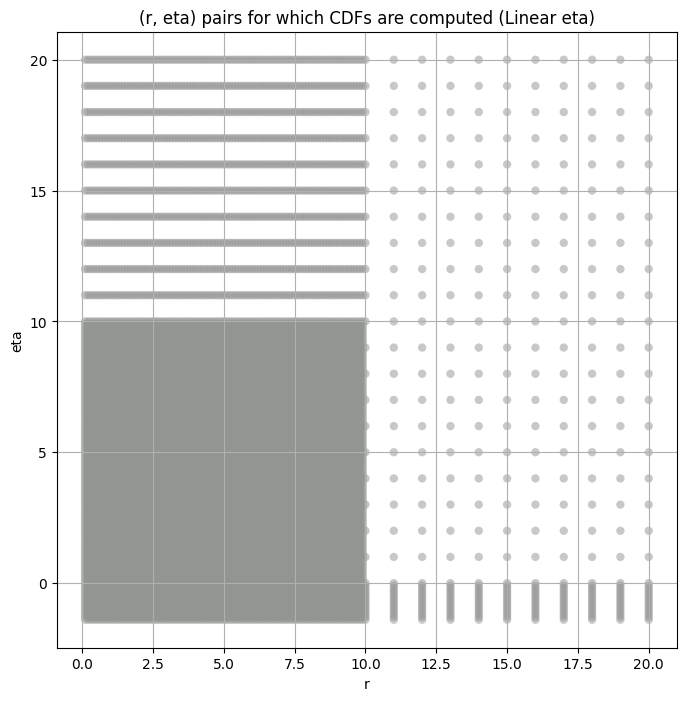

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     3.568306e+14  3.039798e+14  4.195499e+14    9.504944    4.874284   
5     7.959927e+14  7.029293e+14  8.967352e+14   17.538180   14.823676   
8     1.670649e+14  1.450703e+14  1.917868e+14   27.408527   18.534835   
11    1.355468e+13  1.069475e+13  1.834761e+13  121.738546   10.967462   
14    2.103183e+14  1.858708e+14  2.378472e+14   21.087435   14.737431   
17    3.977760e+14  3.729645e+14  4.249828e+14    4.405207    2.939635   
20    1.007255e+14  9.349251e+13  1.087113e+14    6.518887    4.131004   
23    1.091860e+13  1.026927e+13  1.167125e+13    4.128532    2.239955   
26    1.912489e+12  1.798811e+12  2.037603e+12    3.811173    2.372679   
30    2.431388e+10  2.244861e+10  2.633945e+10    7.504837    5.239296   

      kurt_upper  total_samples  
band                             
2      13.495808         1440.0  
5      20.252496         4320.0  
8      40.507572        12240.0  
11    309.820047        33840.0  
14     31.797948        93600.0  
17      8.648835       100000.0  
20     12.301920       100000.0  
23     11.533251       100000.0  
26      8.482887       100000.0  
30     12.814057       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     3.568306e+14   3.568306e+14    2.359806e+14    2.008889e+14   
5     7.959927e+14   7.959927e+14    5.827725e+14    4.813424e+14   
8     1.670649e+14   1.670649e+14    1.372871e+14    1.222128e+14   
11    1.355468e+13   1.355468e+13    1.044760e+13    1.003429e+13   
14    2.103183e+14   2.103183e+14    1.981332e+14    1.910584e+14   
17    3.977760e+14   3.977760e+14    3.878747e+14    3.819933e+14   
20    1.007255e+14   1.007255e+14    9.743147e+13    9.552463e+13   
23    1.091860e+13   1.091860e+13    1.063383e+13    1.047510e+13   
26    1.912489e+12   1.912489e+12    1.866544e+12    1.839839e+12   
30    2.431388e+10   2.431388e+10    2.352464e+10    2.303688e+10   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       1.776227e+14     1.601429e+14     1.339013e+14     1.138426e+14   
5       4.111291e+14     3.601865e+14     2.914682e+14     2.416719e+14   
8       1.119760e+14     1.038659e+14     9.133334e+13     8.180551e+13   
11      9.745271e+12     9.529116e+12     9.174293e+12     8.880374e+12   
14      1.853922e+14     1.804723e+14     1.719800e+14     1.647515e+14   
17      3.770666e+14     3.727175e+14     3.651279e+14     3.585172e+14   
20      9.397768e+13     9.263993e+13     9.034075e+13     8.838268e+13   
23      1.034444e+13     1.023076e+13     1.003442e+13     9.864654e+12   
26      1.817657e+12     1.798096e+12     1.763859e+12     1.733940e+12   
30      2.263332e+10     2.227845e+10     2.166064e+10     2.112785e+10   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        9.774069e+13     8.465898e+13     7.338755e+13     4.794070e+13  
5        2.063253e+14     1.799486e+14     1.601591e+14     1.227792e+14  
8        7.428905e+13     6.829646e+13     6.353769e+13     5.353509e+13  
11       8.635734e+12     8.425132e+12     8.239708e+12     7.798977e+12  
14       1.584603e+14     1.527841e+14     1.476284e+14     1.342328e+14  
17       3.525247e+14     3.470484e+14     3.419558e+14     3.284579e+14  
20       8.663858e+13     8.505582e+13     8.360510e+13     7.980444e+13  
23       9.713206e+12     9.575714e+12     9.448962e+12     9.114081e+12  
26       1.706993e+12     1.682299e+12     1.659413e+12     1.598793e+12  
30       2.065436e+10     2.022539e+10     1.983121e+10     1.880444e+10

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01076539989407753 356830582924206.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.013969422794083117 235980572781386.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.023907858973268893 200888947326534.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.035765490946932266 177622658302326.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0456419440963632 160142937914240.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.06189055022514678 133901257849386.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.07808170443349294 113842633516589.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.09417854421553218 97740689768571.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.10889680831808879 84658978161028.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.12271135116685594 73387546068114.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.165318391842169 47940699953767.66
Number of samples: 2880, Without approximation : 1440.0


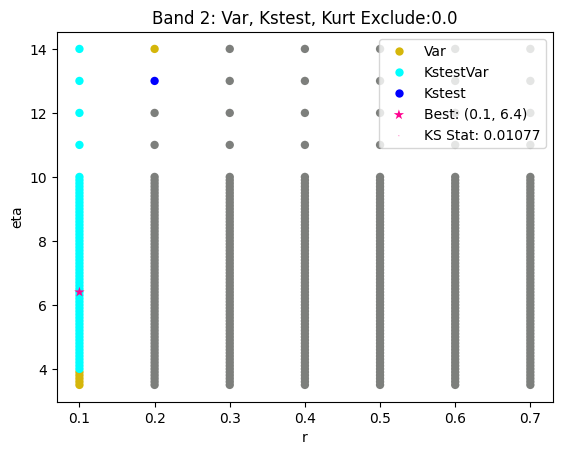

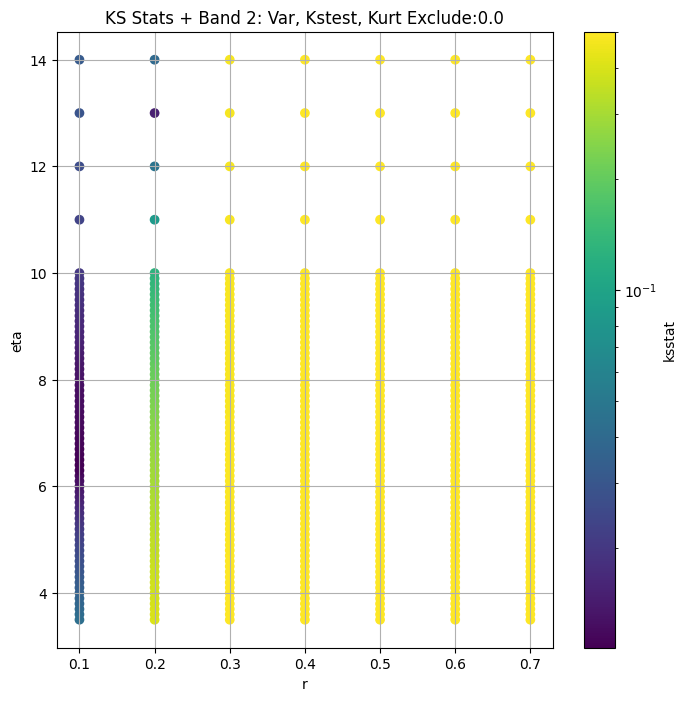

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.024860281287295394 795992728809031.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.017853427764001006 582772494707326.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.013848133956343545 481342376688111.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.014691695168705055 411129066804030.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.01771622370715875 360186455601334.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.022299380093851313 291468233414597.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.026535204558297498 241671898452316.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.032358315873089225 206325283974051.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.039576460543200416 179948561929257.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.045084767692167516 160159059995823.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.05910797386076472 122779231253977.02
Number of samples: 8640, Without approximation : 4320.0


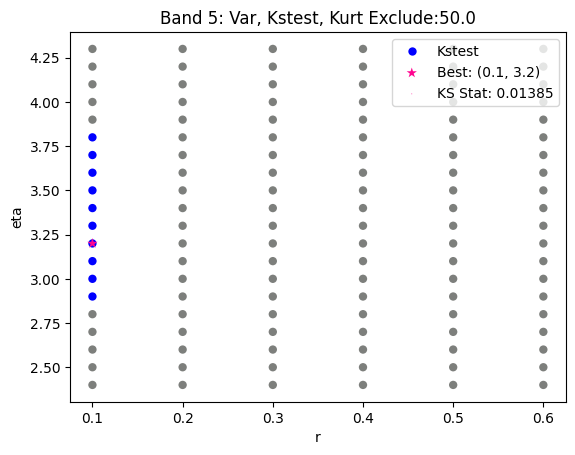

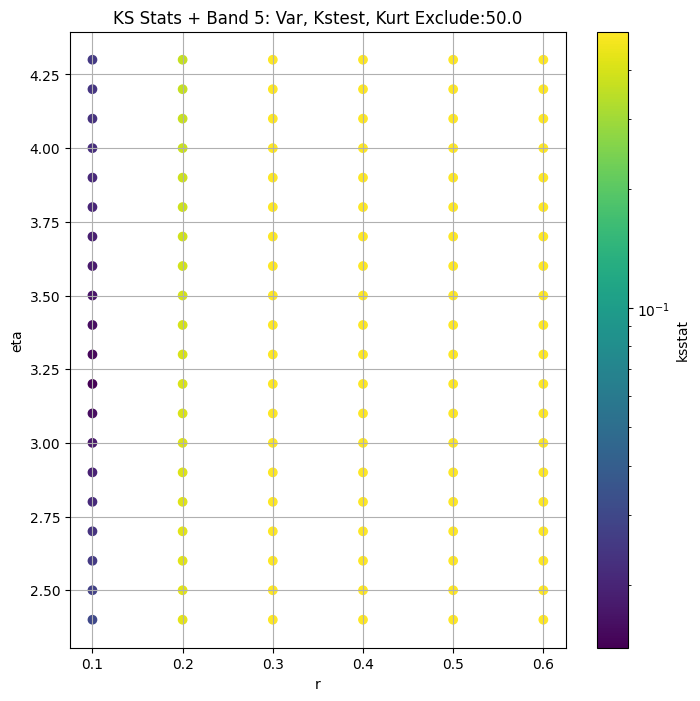

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.01902171937546278 167064852743775.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.01902171937546278 137287052848250.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.01837098768306078 122212782996497.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.016025842174861804 111975987899021.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01401530836215338 103865903838453.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.01048087559682842 91333335003205.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.011359534456775178 81805507700849.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.013123960050168026 74289045043882.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.01537872795915074 68296460982148.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.017301485482301038 63537692085566.09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.02269057509559672 53535087418926.55
Number of samples: 24480, Without approximation : 12240.0


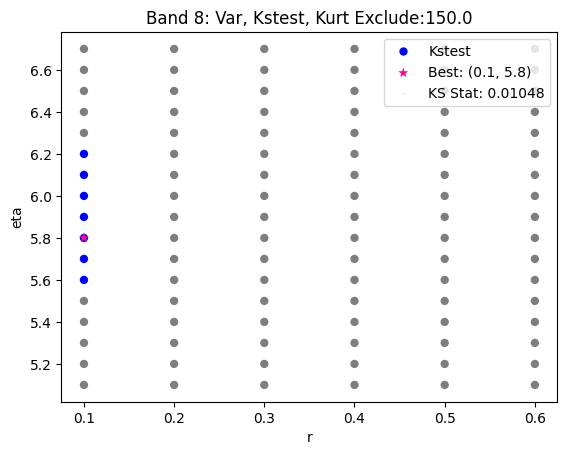

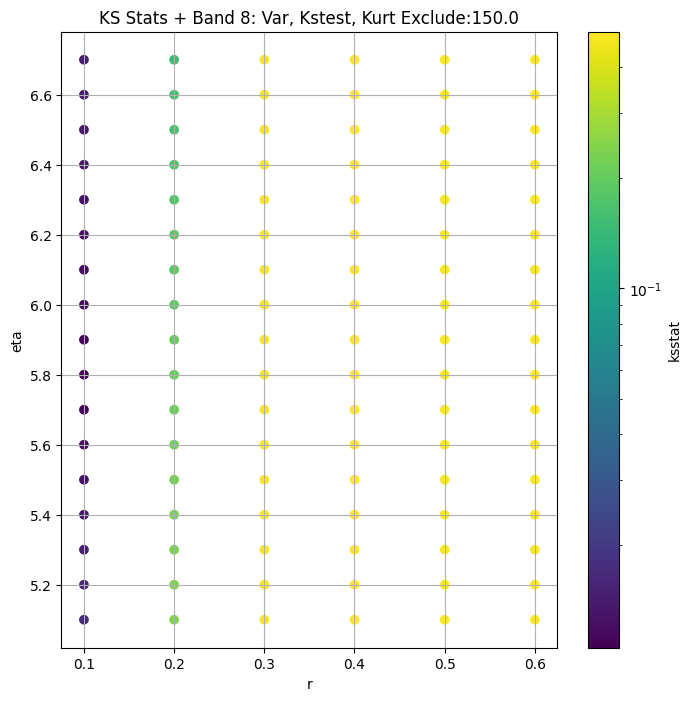

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.009153892604616076 13554683977432.162


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.008834831152050304 10447595970780.838


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.006934263865140788 10034292890542.748


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.005898368103112173 9745271233190.475


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.004975696163893484 9529115807229.113


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.003717768313926384 9174293185666.123


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.004278911266431442 8880373929122.365


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.004905448512609792 8635733703318.271


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.005330990659503265 8425131936392.254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.005834027705425404 8239708387249.719


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.008795762706176324 7798977483861.778
Number of samples: 67680, Without approximation : 33840.0


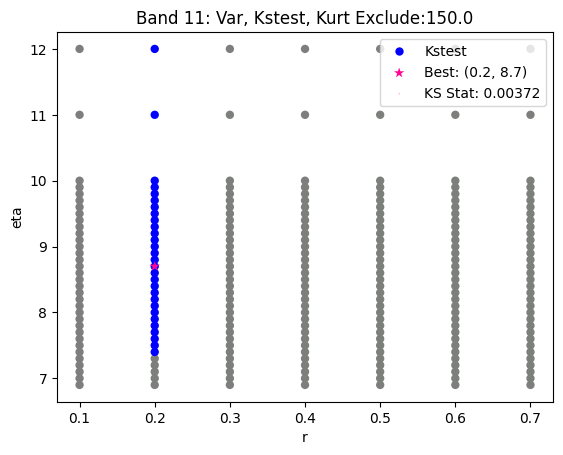

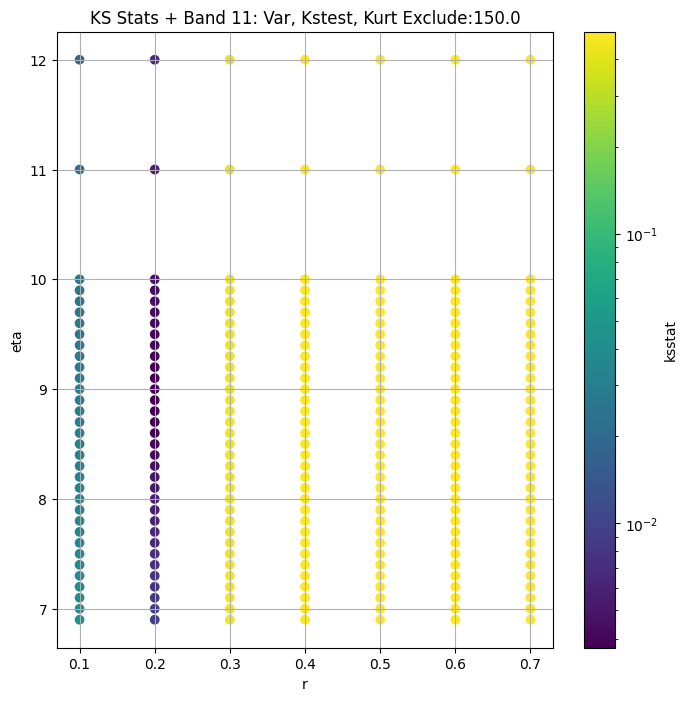

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.0266342197117565 210318286008347.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.02520980327178135 198133243717448.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.02304156653047007 191058407060181.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.022558062406444986 185392155636950.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02335948610870369 180472291002535.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.024773377336189062 171979957125061.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.024048748413839416 164751453645298.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02498675364411726 158460277805975.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02606081545884168 152784090973635.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.026389932423685813 147628449674382.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.027970995354008113 134232759503767.1
Number of samples: 100000, Without approximation : 93600.0


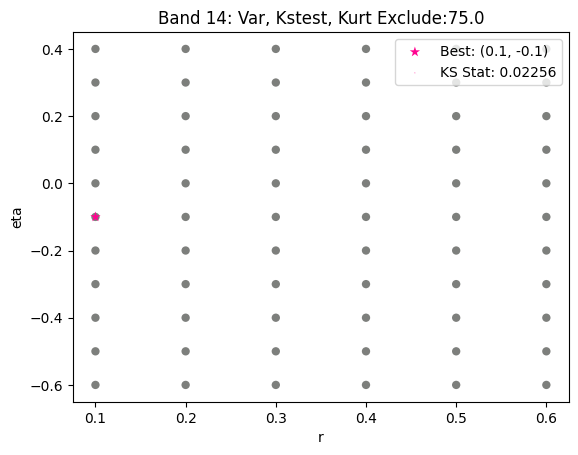

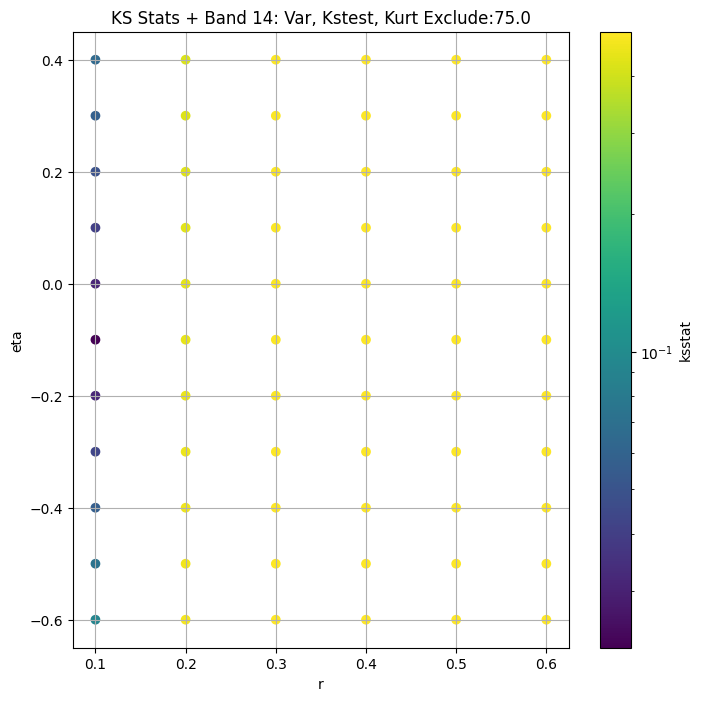

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.00852766690177742 397776025378705.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.009179220336234334 387874658171040.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.009630394837983267 381993314524020.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.009943106555730566 377066641594050.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.010198179469195934 372717504078447.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.010694900394298434 365127897085837.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.01130524845753643 358517246174879.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.011735469798129339 352524717905521.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.012323297489081605 347048397608568.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.012749640370019175 341955790253280.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.014168742373398269 328457855536086.3
Number of samples: 100000, Without approximation : 100000.0


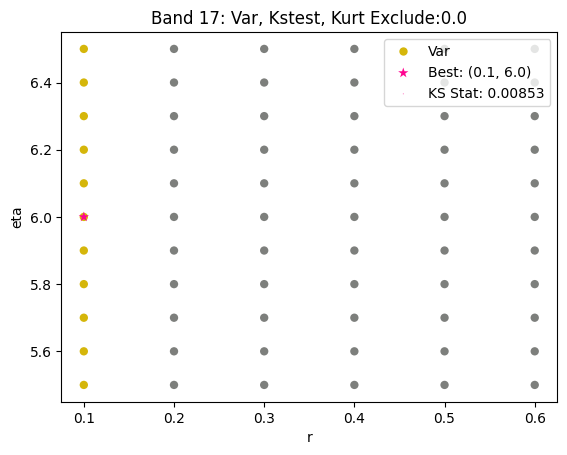

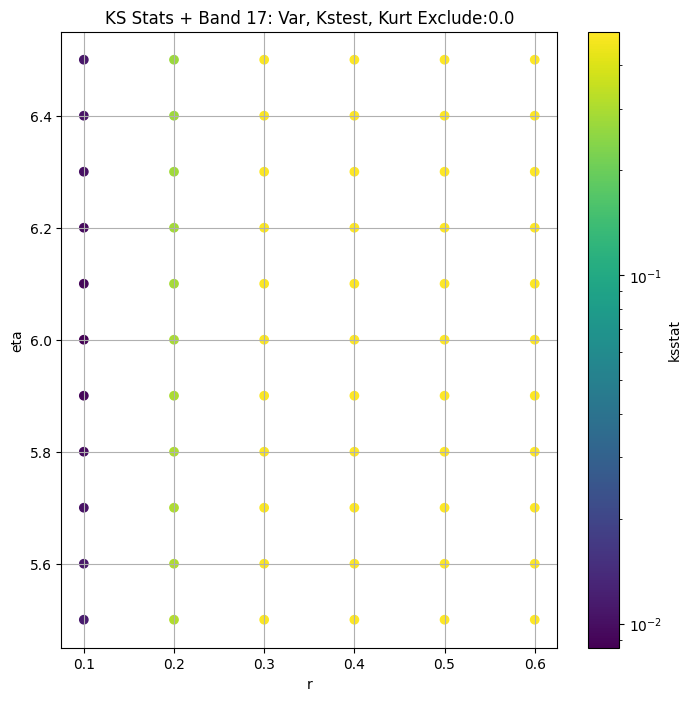

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0022119421525096383 100725452199901.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.001637396016342496 97431468452931.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0019307481852477125 95524633937207.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.002473603731022702 93977683832949.11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0029950472526458667 92639927803421.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.0039353024926244845 90340752562082.83


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.004776174311866201 88382675348153.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.005566699129334007 86638583256639.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.006323127851251921 85055817699833.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.007087864805712656 83605100628999.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.009172876371806575 79804441732364.95
Number of samples: 100000, Without approximation : 100000.0


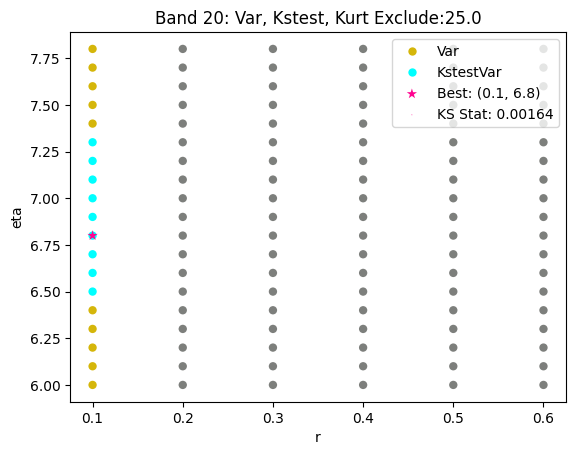

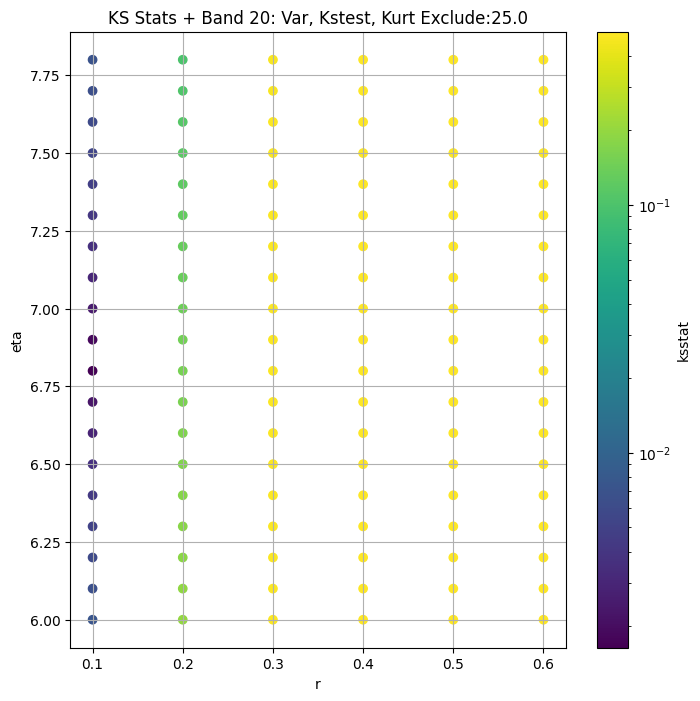

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.002525158750857459 10918595942785.086


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0012173807995357055 10633826200550.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0010442276474422509 10475103446917.492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0013351947860434053 10344444076083.117


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0017095203902064045 10230757547391.355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0025968220223102807 10034422189281.291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.003476618965631735 9864653994359.93


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004317567188590443 9713206053894.521


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005110939663793758 9575713674330.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.005872780556249707 9448962261162.674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.007978177606096946 9114081214766.047
Number of samples: 100000, Without approximation : 100000.0


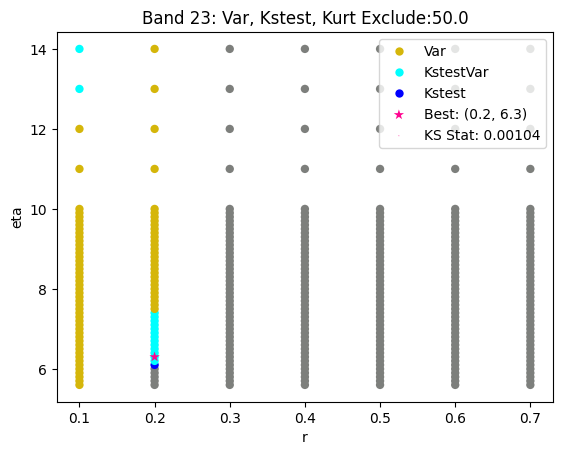

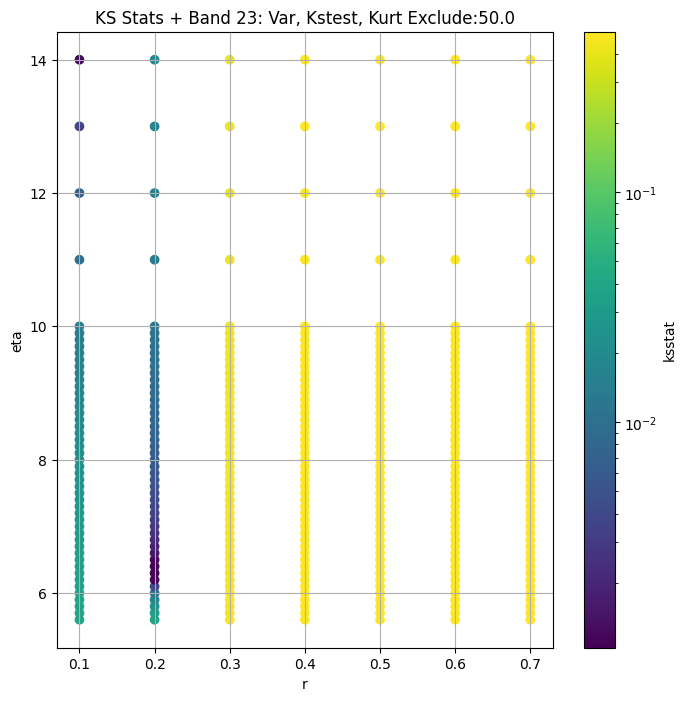

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.00039592649453401574 1912488864502.4934


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0011036676040178106 1866543658469.5544


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0017742857726966502 1839839194460.132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0023501514318365405 1817657390149.0085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.002875632548767326 1798095506864.8752


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.0038337914891281924 1763858941793.4893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004709830484824838 1733940088332.4158


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005528992547683152 1706992765988.0706


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006305922468815721 1682298983170.1855


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.007051534620453555 1659412628590.7515


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.009126839027475117 1598793432897.2532
Number of samples: 100000, Without approximation : 100000.0


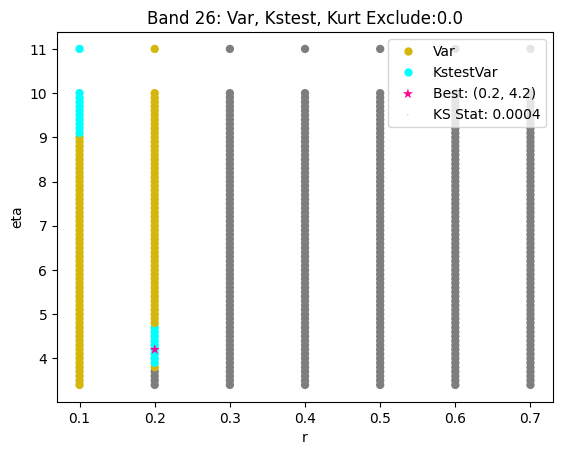

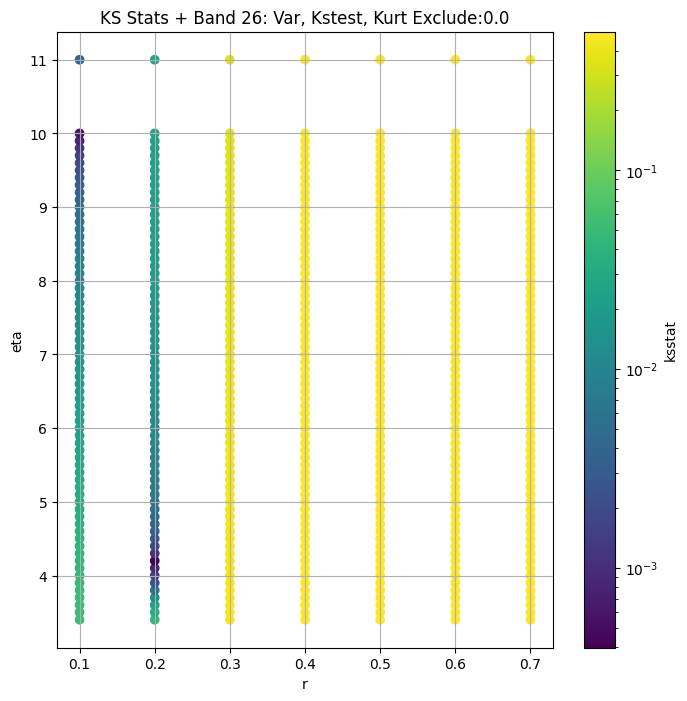

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.002475228201278379 24313879883.08858


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.0020987323830673477 23524639188.073612


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.0027386937138645442 23036875161.568687


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.002759781725439194 22633315031.80073


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.003284076378750219 22278450339.064495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.004252902789936352 21660636024.968517


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.005139071453891614 21127852741.368153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.005970468785408491 20654363309.337635


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.006764383231839567 20225386220.595135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.007528144644876993 19831213817.65268


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.009661805075236583 18804436903.831
Number of samples: 100000, Without approximation : 100000.0


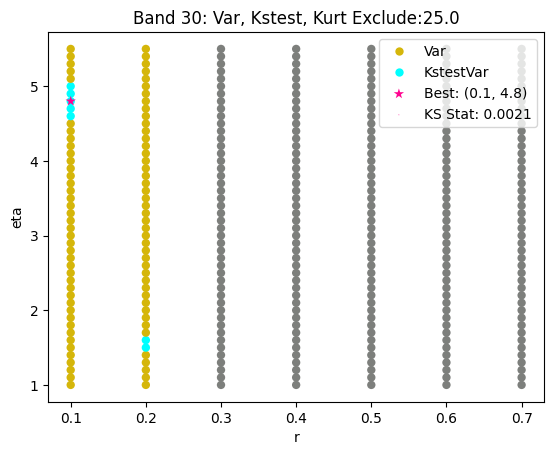

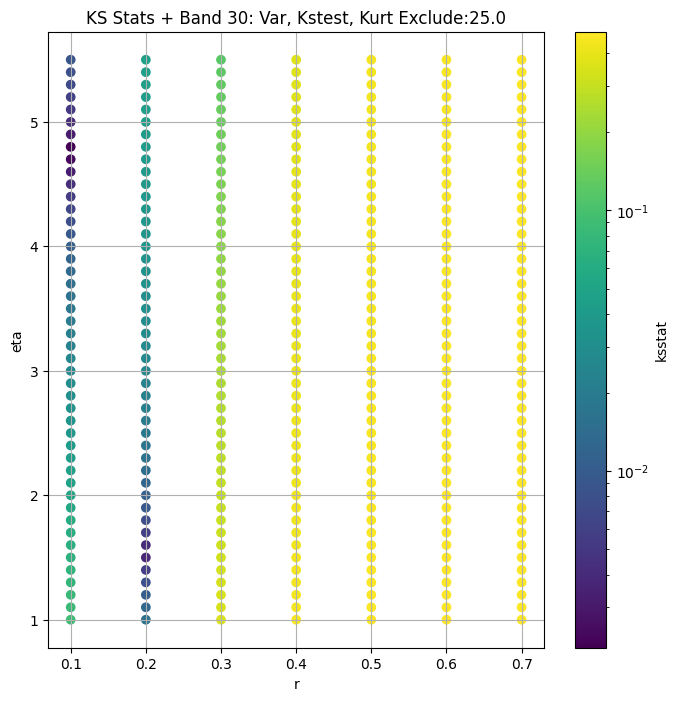

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     3.568306e+14  3.039798e+14  4.195499e+14    9.504944    4.874284   
5     7.959927e+14  7.029293e+14  8.967352e+14   17.538180   14.823676   
8     1.670649e+14  1.450703e+14  1.917868e+14   27.408527   18.534835   
11    1.355468e+13  1.069475e+13  1.834761e+13  121.738546   10.967462   
14    2.103183e+14  1.858708e+14  2.378472e+14   21.087435   14.737431   
17    3.977760e+14  3.729645e+14  4.249828e+14    4.405207    2.939635   
20    1.007255e+14  9.349251e+13  1.087113e+14    6.518887    4.131004   
23    1.091860e+13  1.026927e+13  1.167125e+13    4.128532    2.239955   
26    1.912489e+12  1.798811e+12  2.037603e+12    3.811173    2.372679   
30    2.431388e+10  2.244861e+10  2.633945e+10    7.504837    5.239296   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.495808         1440.0             0.010765        0.1          6.4   
5      20.252496         4320.0             0.013848        0.1          3.2   
8      40.507572        12240.0             0.010481        0.1          5.8   
11    309.820047        33840.0             0.003718        0.2          8.7   
14     31.797948        93600.0             0.022558        0.1         -0.1   
17      8.648835       100000.0             0.008528        0.1          6.0   
20     12.301920       100000.0             0.001637        0.1          6.8   
23     11.533251       100000.0             0.001044        0.2          6.3   
26      8.482887       100000.0             0.000396        0.2          4.2   
30     12.814057       100000.0             0.002099        0.1          4.8   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.178560e-05                     0.0        3.568306e+14   
5      3.725247e-03                    50.0        4.813424e+14   
8      1.176518e-05                   150.0        9.133334e+13   
11     2.197692e+04                   150.0        9.174293e+12   
14     4.465574e+01                    75.0        1.853922e+14   
17     3.970133e-05                     0.0        3.977760e+14   
20     3.723581e-06                    25.0        9.743147e+13   
23     9.068430e+04                    50.0        1.047510e+13   
26     7.285146e+04                     0.0        1.912489e+12   
30     1.208992e-08                    25.0        2.352464e+10   

      kstest_stat_cutoff_0.05  
band                           
2                    0.035671  
5                    0.020624  
8                    0.012262  
11                   0.007378  
14                   0.004437  
17                   0.004293  
20                   0.004293  
23                   0.004293  
26                   0.004293  
30                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.05896609333674882, var: 160142937914240.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.04840726808118989, var: 177622658302326.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.03568993923393837, var: 200888947326534.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.020980221375734187, var: 235980572781386.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.01076539989407753, var: 356830582924206.06
Number of samples: 2880, Without approximation : 1440.0


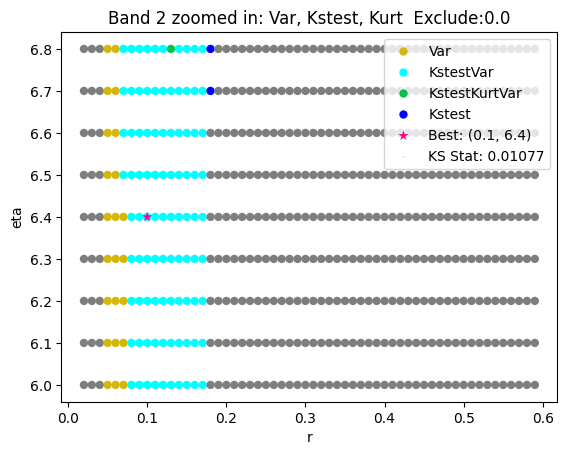

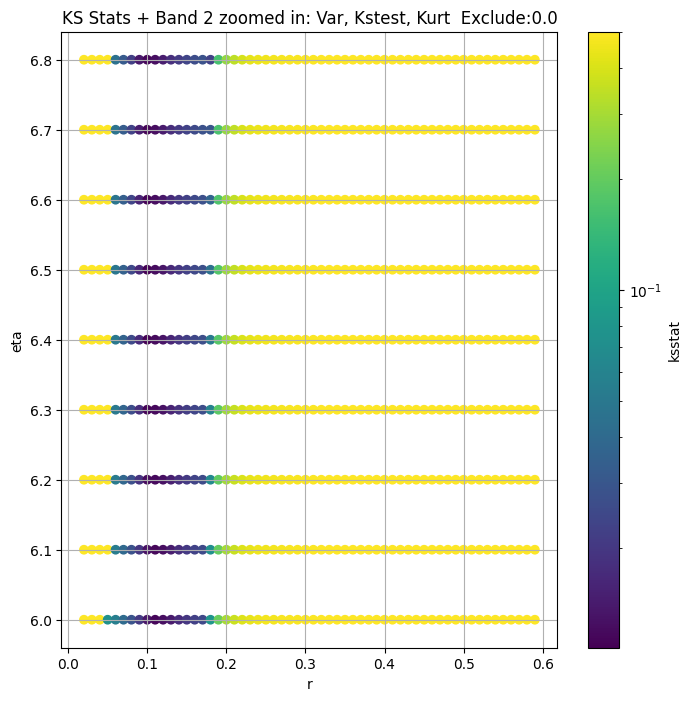

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 50.0 + 100 = 150, ksstat: 0.0222023239892233, var: 291468233414597.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 50.0 + 75 = 125, ksstat: 0.020037285617352074, var: 321940048017791.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 50.0 + 50 = 100, ksstat: 0.017632759678253396, var: 360186455601334.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 50.0 + 25 = 75, ksstat: 0.014603001438298752, var: 411129066804030.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 50.0 + 0 = 50, ksstat: 0.013848133956343545, var: 481342376688111.7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 50.0 + -25 = 25, ksstat: 0.018057428729634395, var: 582772494707326.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 50.0 + -50 = 0, ksstat: 0.018267008197860424, var: 795992728809031.6
Number of samples: 8640, Without approximation : 4320.0


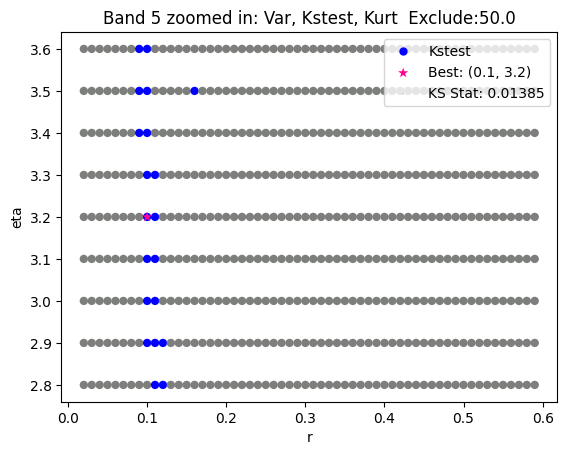

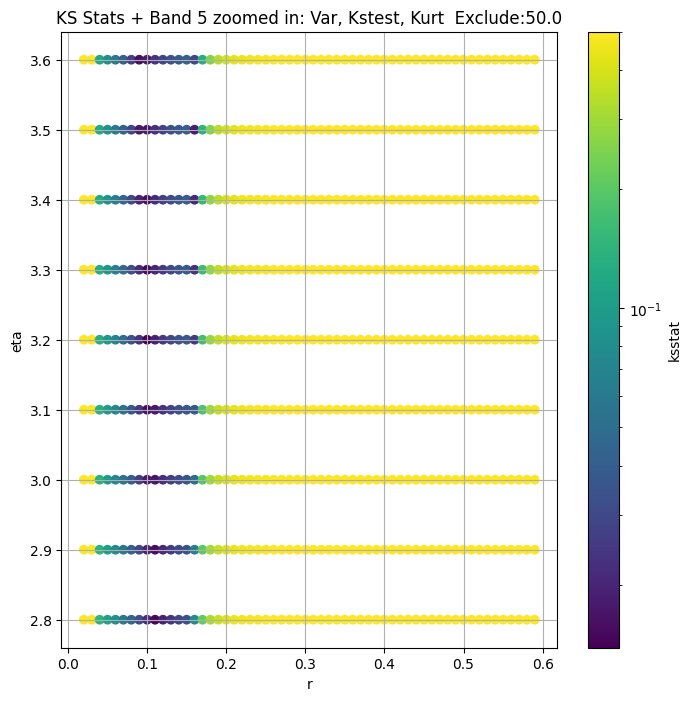

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + 100 = 250, ksstat: 0.013114014827023457, var: 74289045043882.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + 75 = 225, ksstat: 0.01218614267881692, var: 77824467474986.53


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + 50 = 200, ksstat: 0.011351619007495664, var: 81805507700849.98


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + 25 = 175, ksstat: 0.010448052934567409, var: 86299174393050.08


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + 0 = 150, ksstat: 0.01048087559682842, var: 91333335003205.98


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + -25 = 125, ksstat: 0.012090684155705356, var: 97047590054325.89


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + -50 = 100, ksstat: 0.013855261264518082, var: 103865903838453.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + -75 = 75, ksstat: 0.015905657082255664, var: 111975987899021.19


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 150.0 + -100 = 50, ksstat: 0.017672273203807598, var: 122212782996497.47
Number of samples: 24480, Without approximation : 12240.0


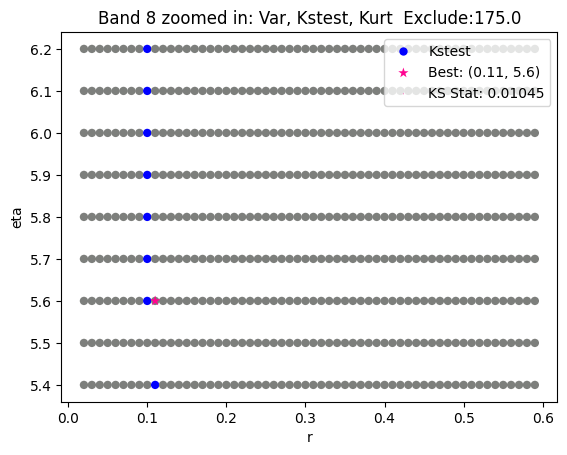

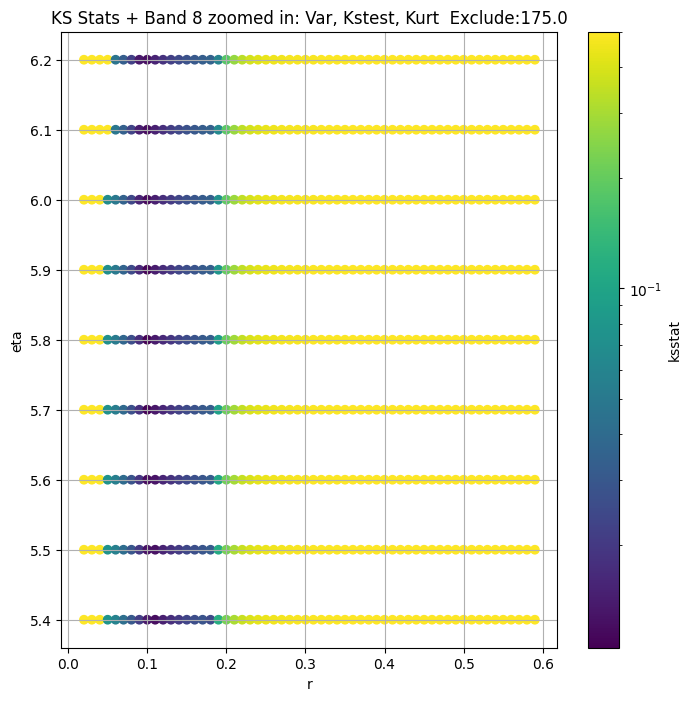

Band 11


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 100 = 250, ksstat: 0.0064010232466404915, var: 8635733703318.271


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 75 = 225, ksstat: 0.005139868133656522, var: 8751793698736.153


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 50 = 200, ksstat: 0.004290647154179705, var: 8880373929122.365


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 25 = 175, ksstat: 0.004004721951538471, var: 9020999955994.96


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 0 = 150, ksstat: 0.003717768313926384, var: 9174293185666.123


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -25 = 125, ksstat: 0.004117212623288347, var: 9342953179151.742


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -50 = 100, ksstat: 0.004906454427508741, var: 9529115807229.113


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -75 = 75, ksstat: 0.005765052937406201, var: 9745271233190.475


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -100 = 50, ksstat: 0.00680831558941386, var: 10034292890542.748
Number of samples: 67680, Without approximation : 33840.0


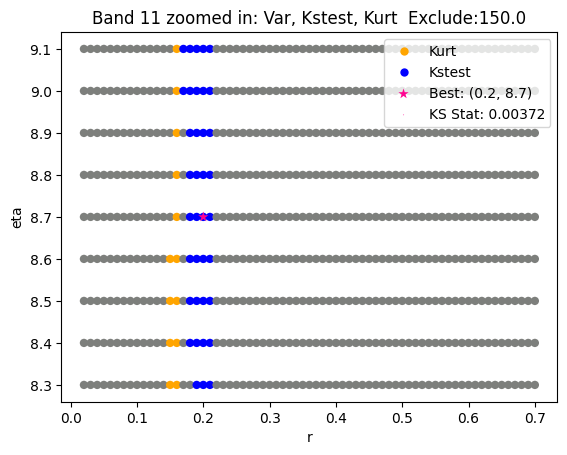

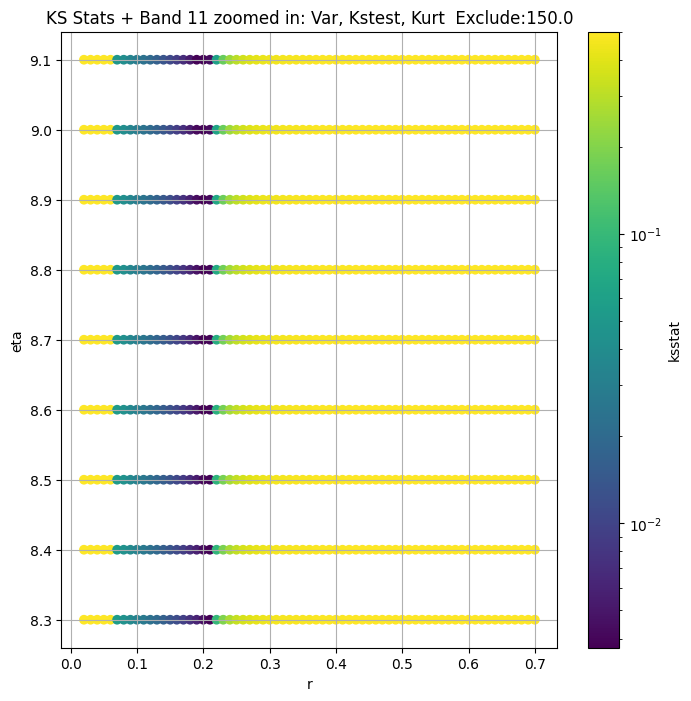

Band 14


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 75.0 + 100 = 175, ksstat: 0.02362696873027223, var: 168224535811468.88


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 75.0 + 75 = 150, ksstat: 0.023083015829752876, var: 171979957125061.44


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 75.0 + 50 = 125, ksstat: 0.023157696591513538, var: 176044998229750.9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 75.0 + 25 = 100, ksstat: 0.022707358618246354, var: 180472291002535.9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 75.0 + 0 = 75, ksstat: 0.022315843406632965, var: 185392155636950.28


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 75.0 + -25 = 50, ksstat: 0.02199617454677283, var: 191058407060181.8


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 75.0 + -50 = 25, ksstat: 0.02203563297573985, var: 198133243717448.9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 75.0 + -75 = 0, ksstat: 0.022545558401740273, var: 210318286008347.97
Number of samples: 100000, Without approximation : 93600.0


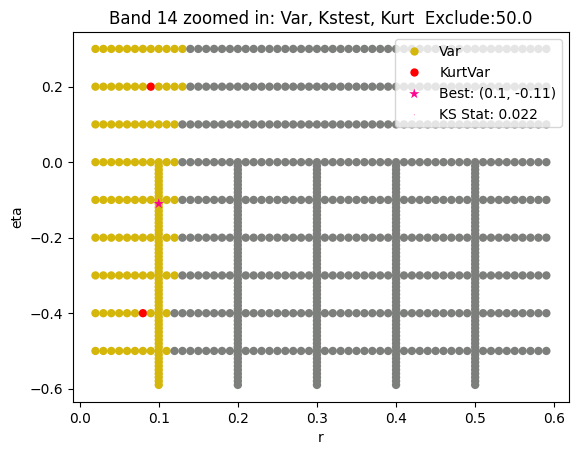

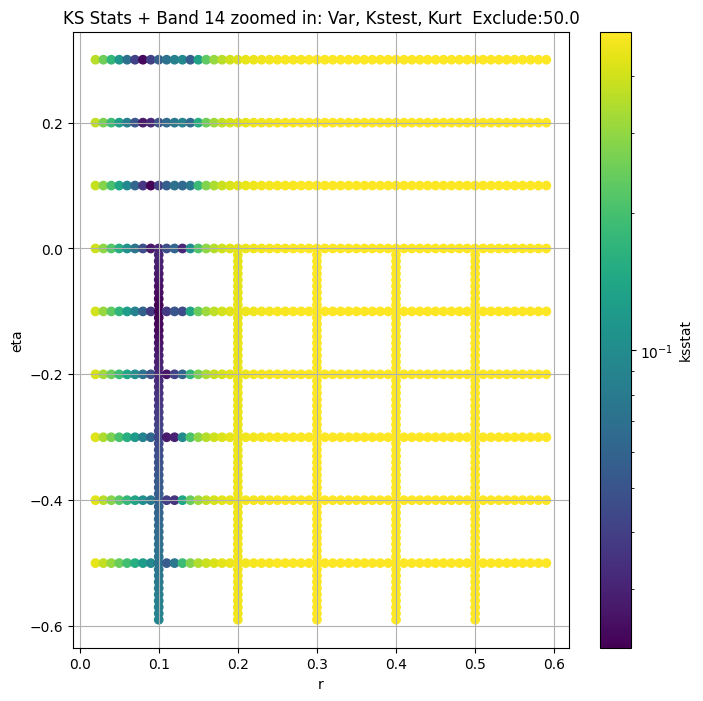

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.010144910670912027, var: 372717504078447.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.009815697355463837, var: 377066641594050.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.009369584856493862, var: 381993314524020.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.008985767555076296, var: 387874658171040.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.00852766690177742, var: 397776025378705.06
Number of samples: 100000, Without approximation : 100000.0


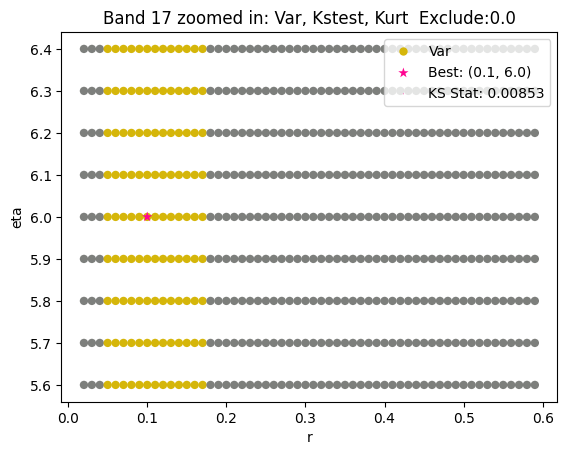

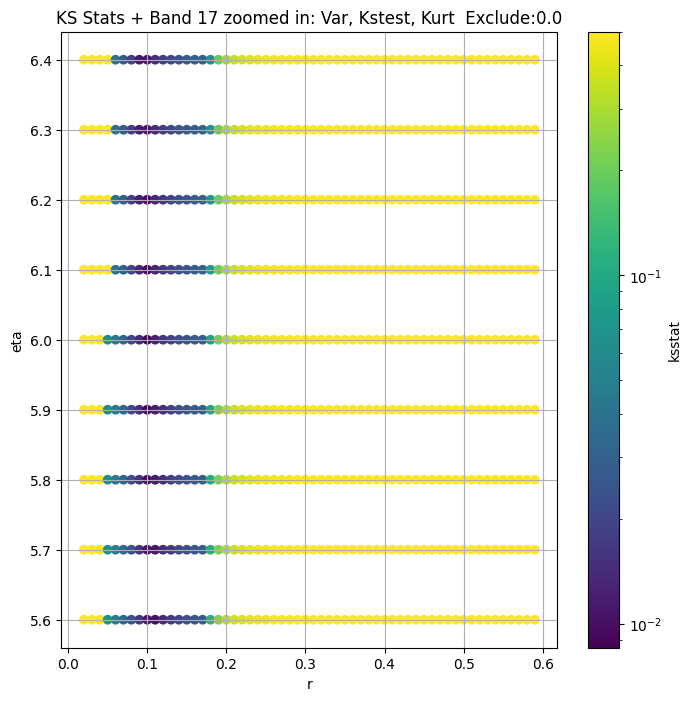

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.0034286543795328008, var: 91438167805706.52


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.002957497135508462, var: 92639927803421.55


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.0024413578197609274, var: 93977683832949.11


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.0019307481852477125, var: 95524633937207.05


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.001637396016342496, var: 97431468452931.23


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0022119421525096383, var: 100725452199901.78
Number of samples: 100000, Without approximation : 100000.0


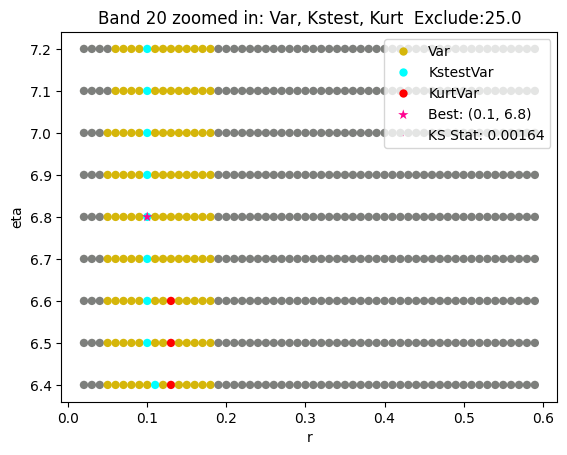

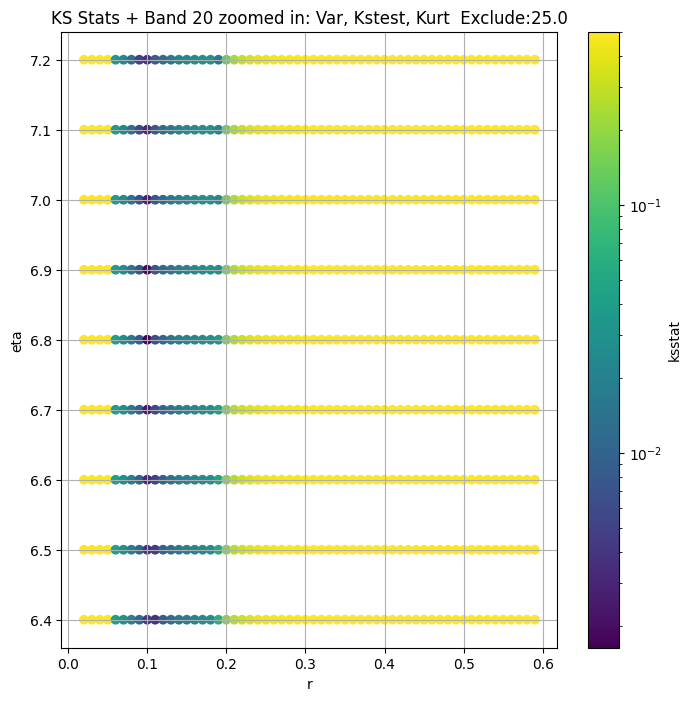

Band 23


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 100 = 150, ksstat: 0.003003310827227851, var: 10034422189281.291


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 75 = 125, ksstat: 0.002131563094988395, var: 10128377161908.36


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 50 = 100, ksstat: 0.0017095203902064045, var: 10230757547391.355


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 25 = 75, ksstat: 0.0013351947860434053, var: 10344444076083.117


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 0 = 50, ksstat: 0.0010333701465027115, var: 10475103446917.492


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + -25 = 25, ksstat: 0.0012827166205088836, var: 10633826200550.42


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + -50 = 0, ksstat: 0.002270898619670003, var: 10918595942785.086
Number of samples: 100000, Without approximation : 100000.0


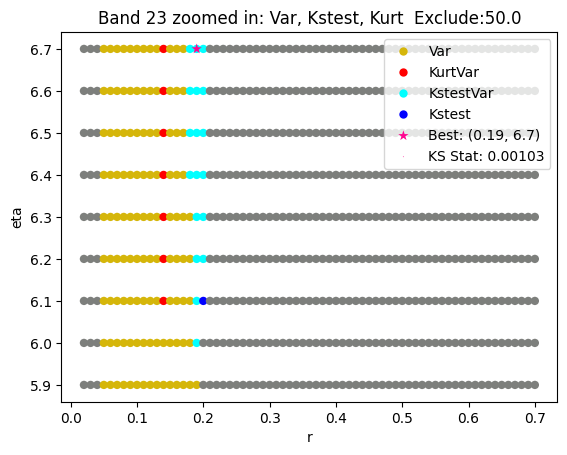

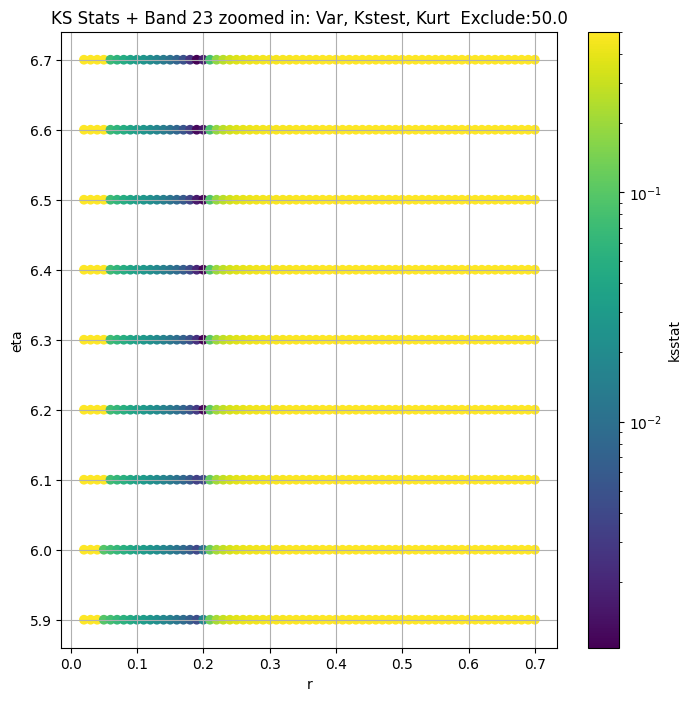

Band 26


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.0037524780158006144, var: 1798095506864.8752


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.002829279699690268, var: 1817657390149.0085


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.0019520627912620186, var: 1839839194460.132


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.0011036676040178106, var: 1866543658469.5544


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.0002982136477612807, var: 1912488864502.4934
Number of samples: 100000, Without approximation : 100000.0


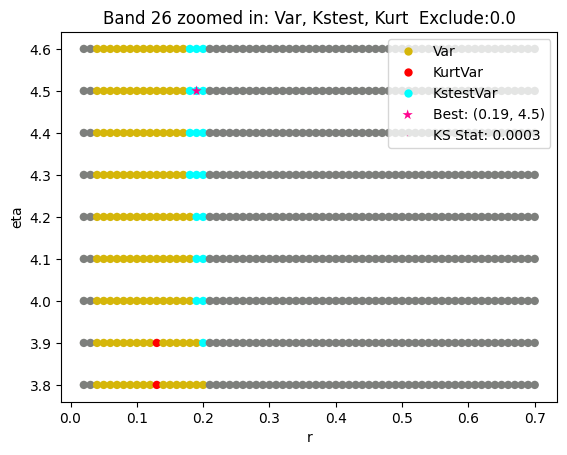

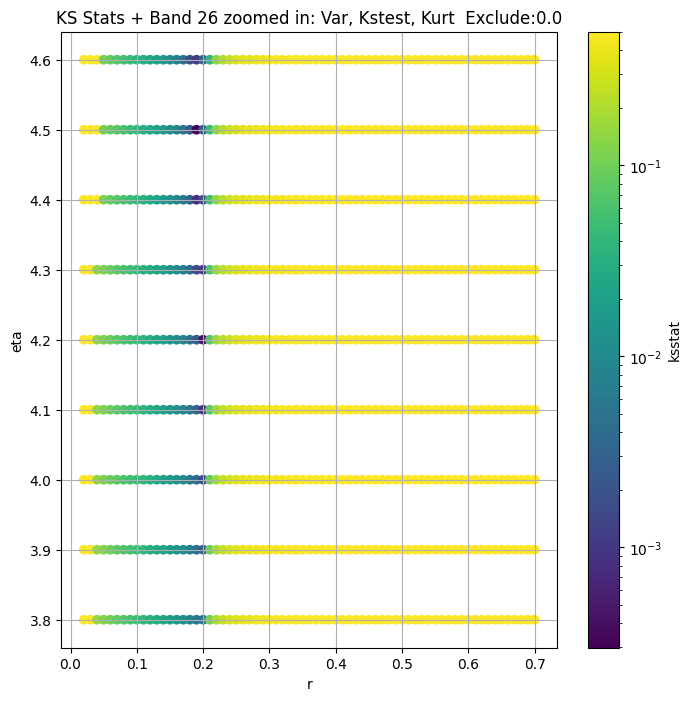

Band 30


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 100 = 125, ksstat: 0.004185328286000774, var: 21956587727.657654


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 75 = 100, ksstat: 0.003747525902266423, var: 22278450339.064495


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 50 = 75, ksstat: 0.0032328932279034744, var: 22633315031.80073


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 25 = 50, ksstat: 0.002663502881932081, var: 23036875161.568687


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + 0 = 25, ksstat: 0.0020987323830673477, var: 23524639188.073612


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 25.0 + -25 = 0, ksstat: 0.00230284345030779, var: 24313879883.08858
Number of samples: 100000, Without approximation : 100000.0


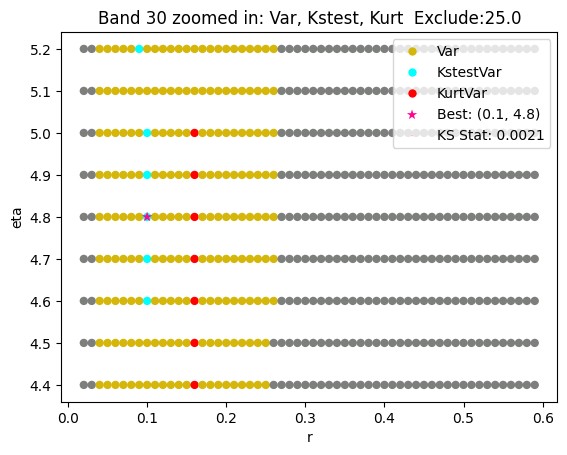

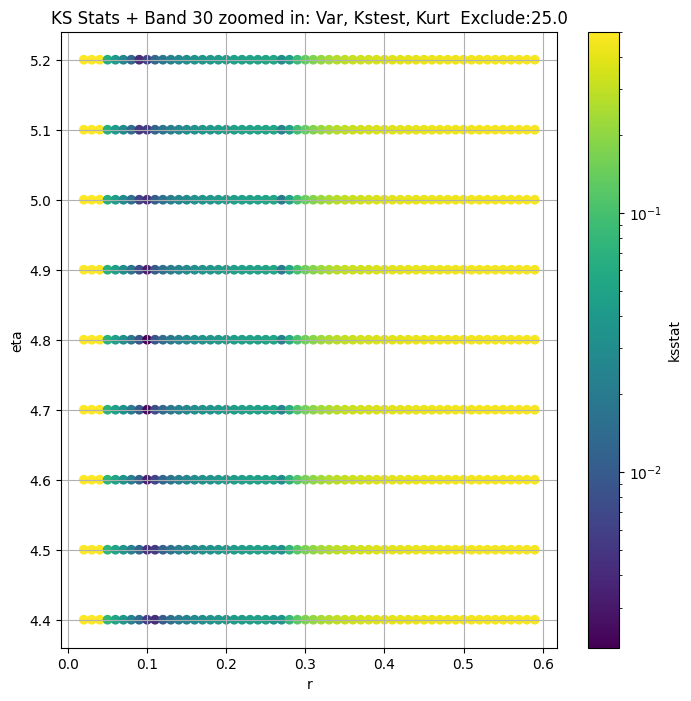

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     3.568306e+14  3.039798e+14  4.195499e+14    9.504944    4.874284   
5     7.959927e+14  7.029293e+14  8.967352e+14   17.538180   14.823676   
8     1.670649e+14  1.450703e+14  1.917868e+14   27.408527   18.534835   
11    1.355468e+13  1.069475e+13  1.834761e+13  121.738546   10.967462   
14    2.103183e+14  1.858708e+14  2.378472e+14   21.087435   14.737431   
17    3.977760e+14  3.729645e+14  4.249828e+14    4.405207    2.939635   
20    1.007255e+14  9.349251e+13  1.087113e+14    6.518887    4.131004   
23    1.091860e+13  1.026927e+13  1.167125e+13    4.128532    2.239955   
26    1.912489e+12  1.798811e+12  2.037603e+12    3.811173    2.372679   
30    2.431388e+10  2.244861e+10  2.633945e+10    7.504837    5.239296   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.495808         1440.0             0.010765        0.1          6.4   
5      20.252496         4320.0             0.013848        0.1          3.2   
8      40.507572        12240.0             0.010481        0.1          5.8   
11    309.820047        33840.0             0.003718        0.2          8.7   
14     31.797948        93600.0             0.022558        0.1         -0.1   
17      8.648835       100000.0             0.008528        0.1          6.0   
20     12.301920       100000.0             0.001637        0.1          6.8   
23     11.533251       100000.0             0.001044        0.2          6.3   
26      8.482887       100000.0             0.000396        0.2          4.2   
30     12.814057       100000.0             0.002099        0.1          4.8   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.178560e-05                     0.0        3.568306e+14   
5      3.725247e-03                    50.0        4.813424e+14   
8      1.176518e-05                   150.0        8.629917e+13   
11     2.197692e+04                   150.0        9.174293e+12   
14     4.465574e+01                    75.0        1.910584e+14   
17     3.970133e-05                     0.0        3.977760e+14   
20     3.723581e-06                    25.0        9.743147e+13   
23     9.068430e+04                    50.0        1.047510e+13   
26     7.285146e+04                     0.0        1.912489e+12   
30     1.208992e-08                    25.0        2.352464e+10   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.035671          0.010765    0.10      6.40   
5                    0.020624          0.013848    0.10      3.20   
8                    0.012262          0.010448    0.11      5.60   
11                   0.007378          0.003718    0.20      8.70   
14                   0.004437          0.021996    0.10     -0.11   
17                   0.004293          0.008528    0.10      6.00   
20                   0.004293          0.001637    0.10      6.80   
23                   0.004293          0.001033    0.19      6.70   
26                   0.004293          0.000298    0.19      4.50   
30                   0.004293          0.002099    0.10      4.80   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     2.178560e-05                  0.0        16402  
5     3.725247e-03                 50.0         9720  
8     1.760081e-03                175.0        17425  
11    2.197692e+04                150.0       128485  
14    4.865052e+01                 50.0         3699  
17    3.970133e-05                  0.0        25000  
20    3.723581e-06                 25.0       720810  
23    2.021269e+04              

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

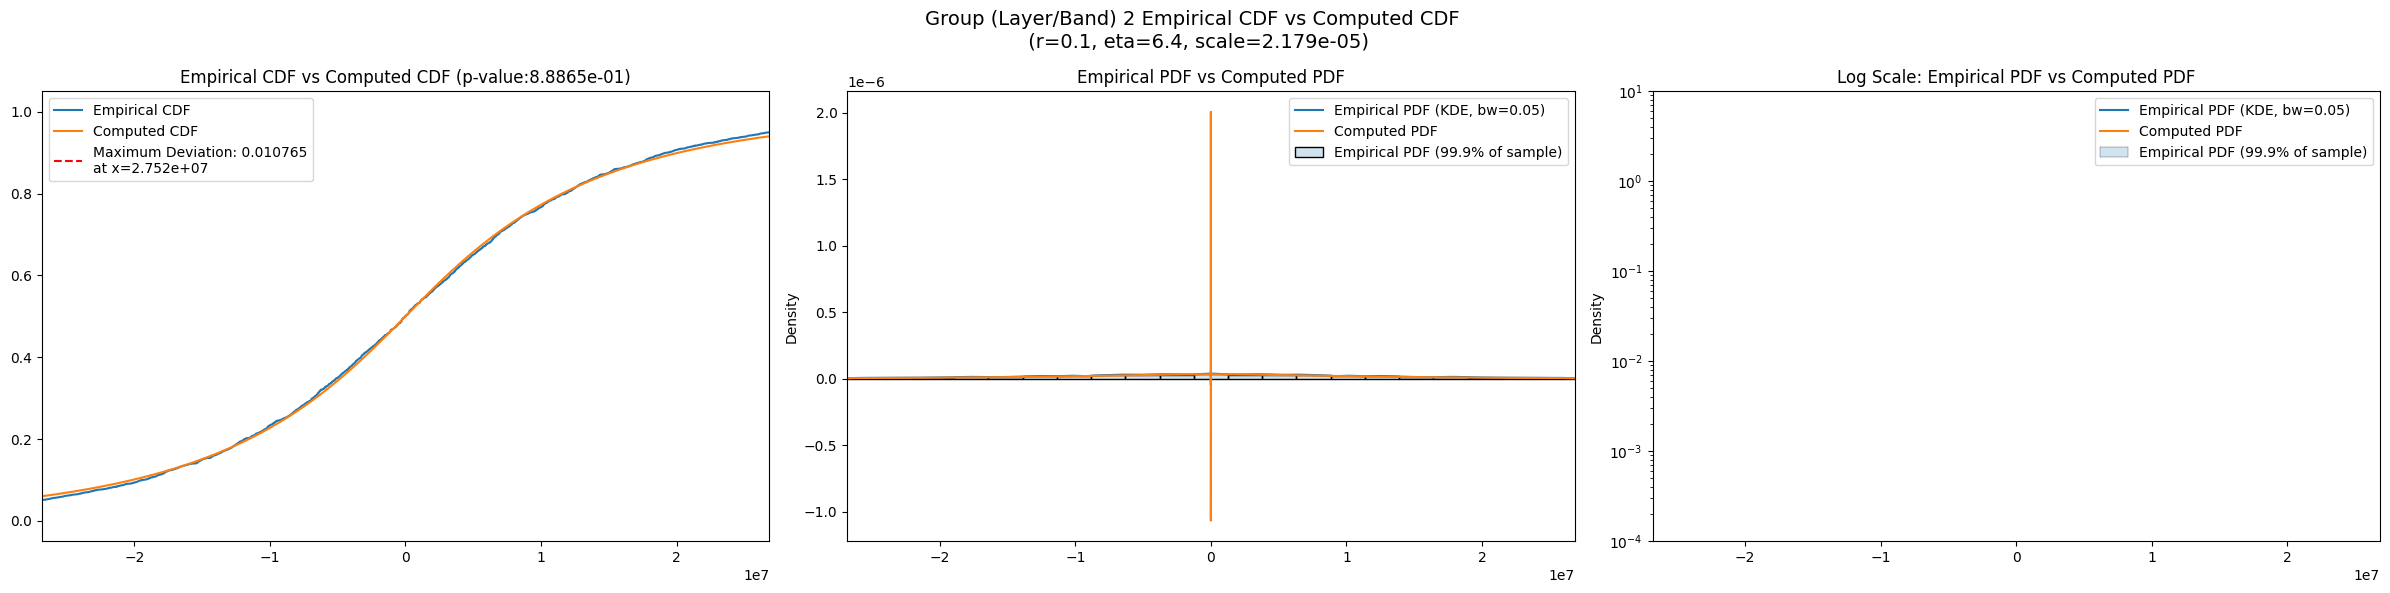

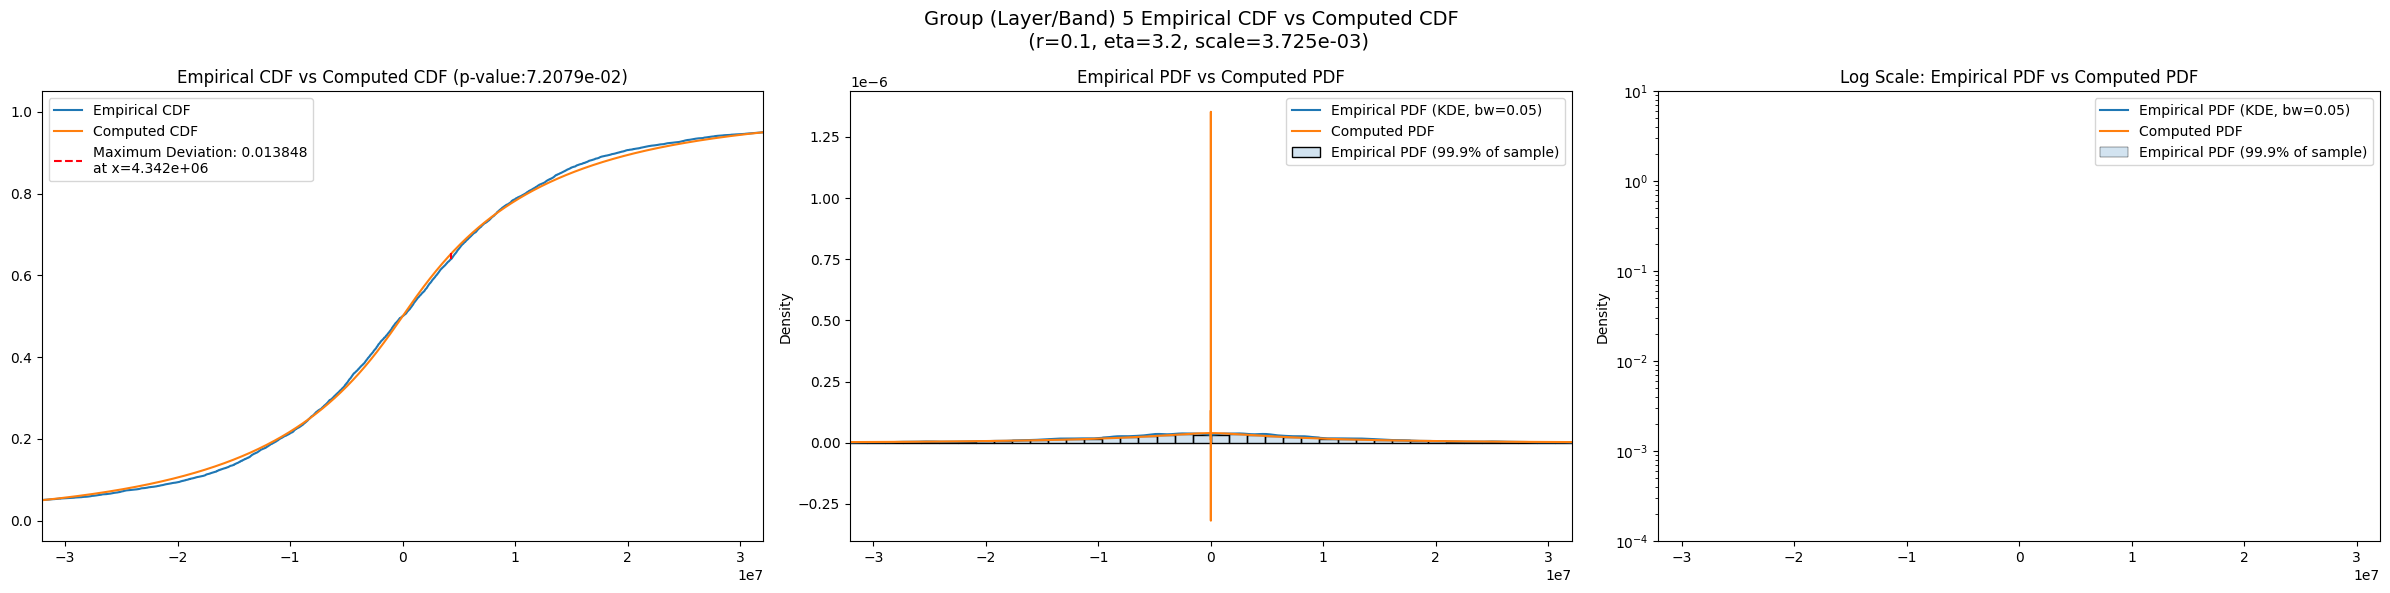

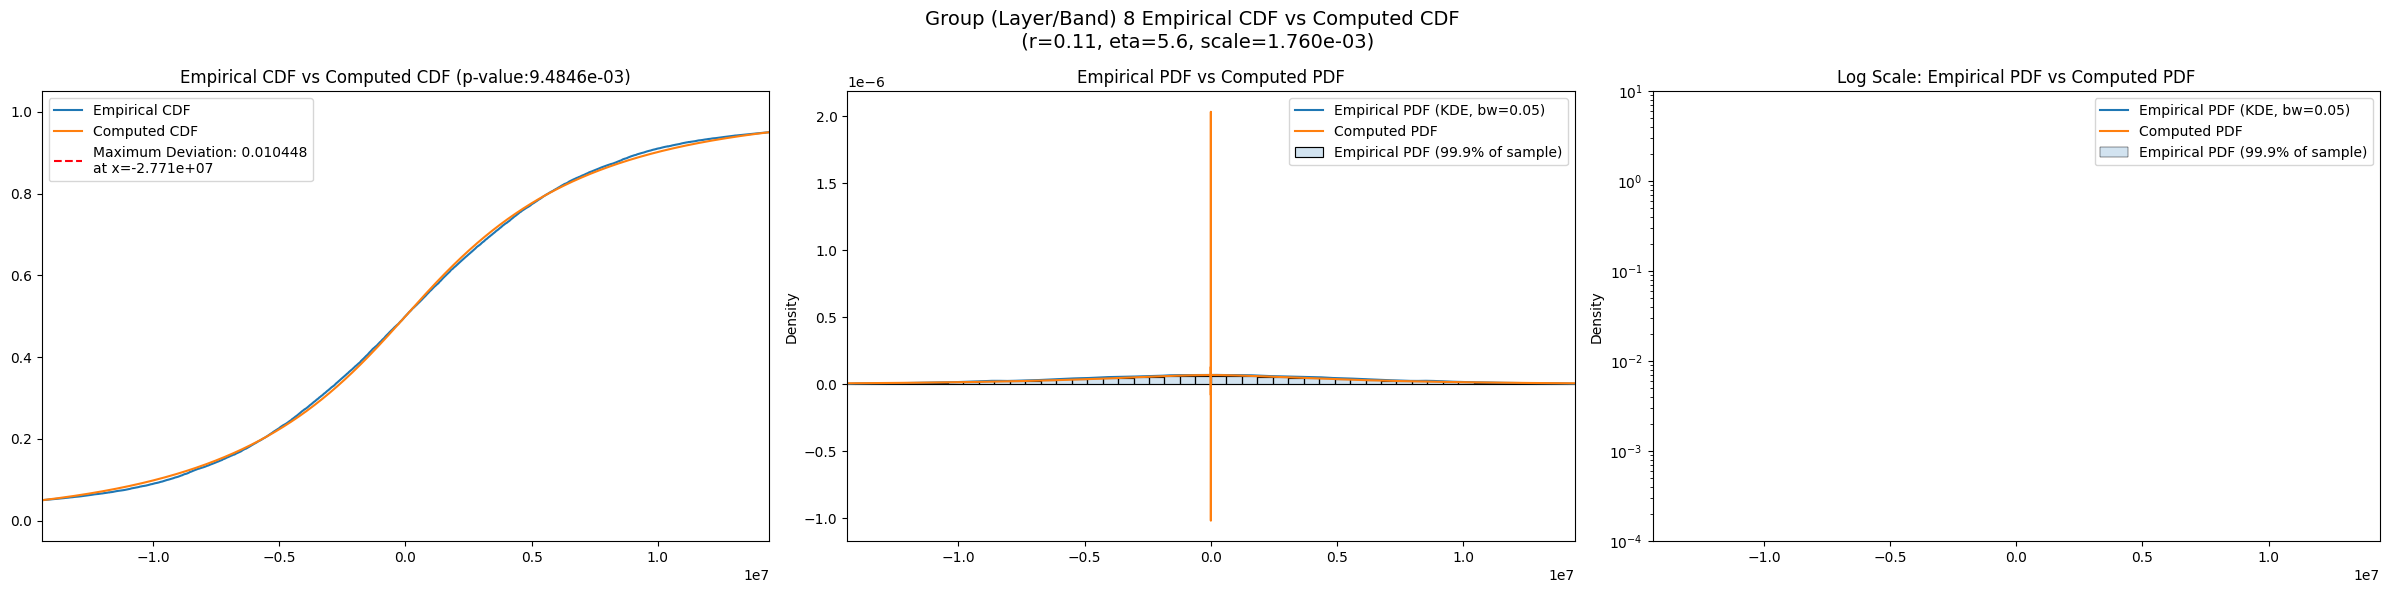

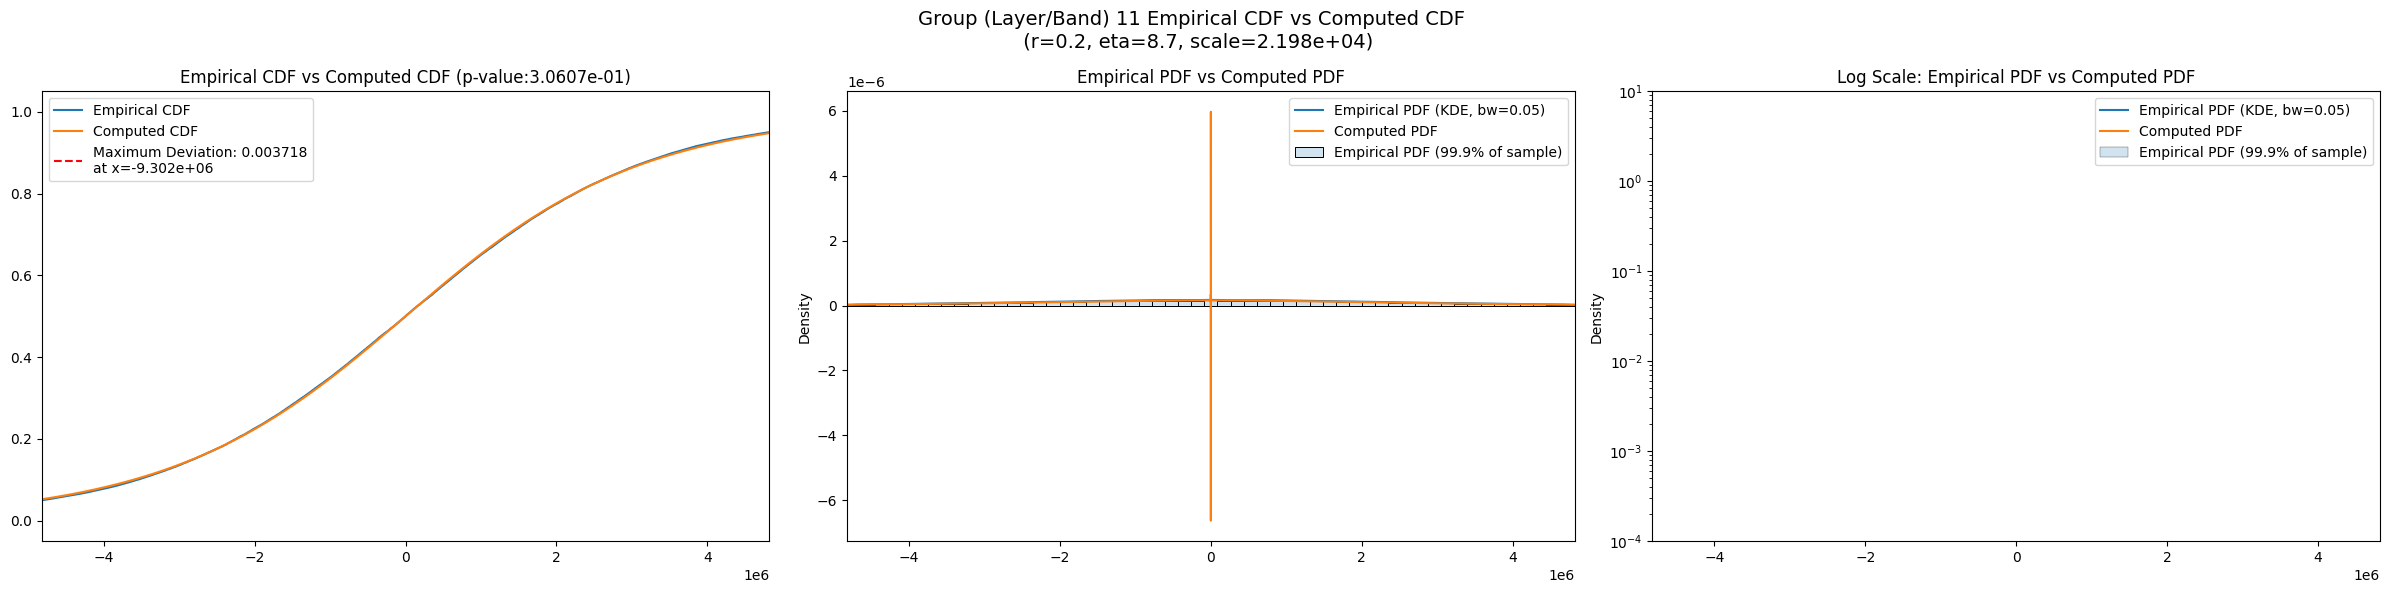

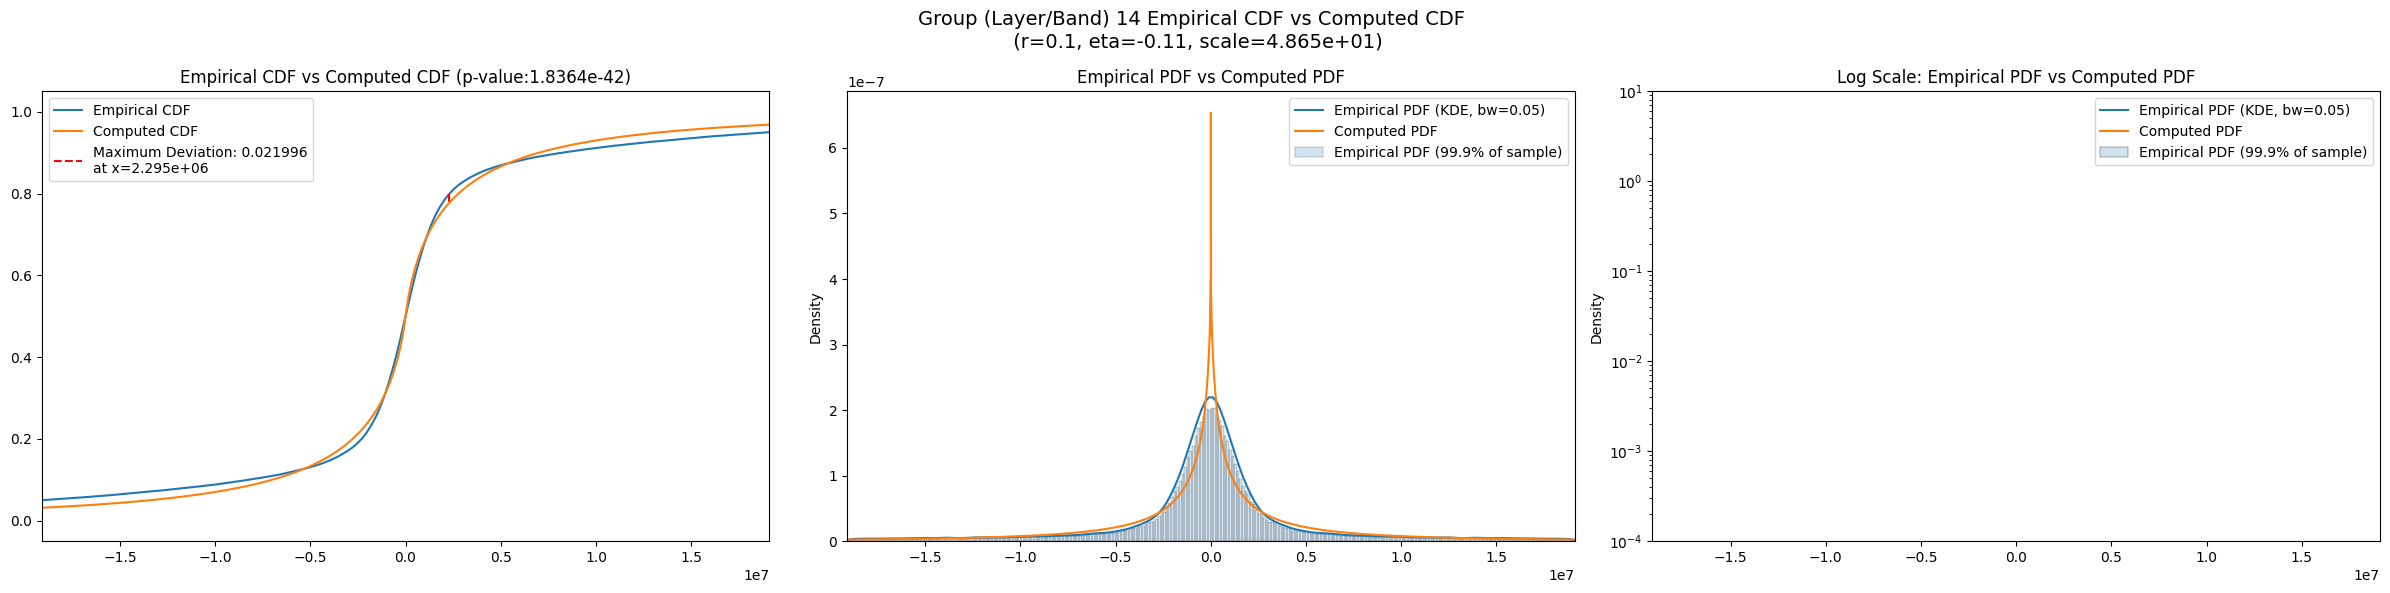

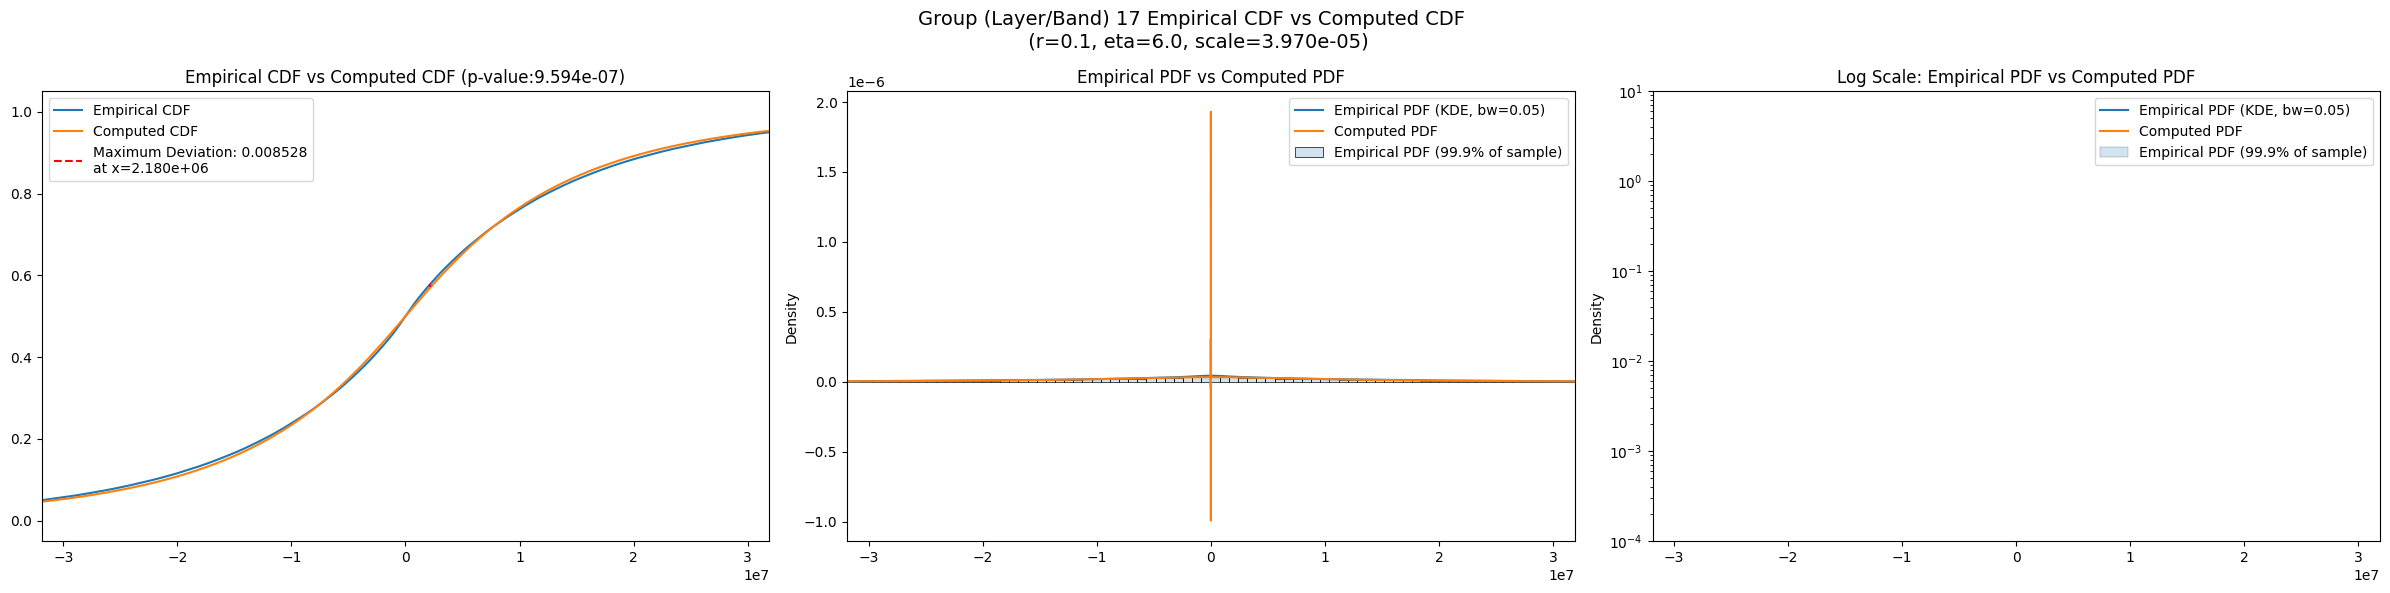

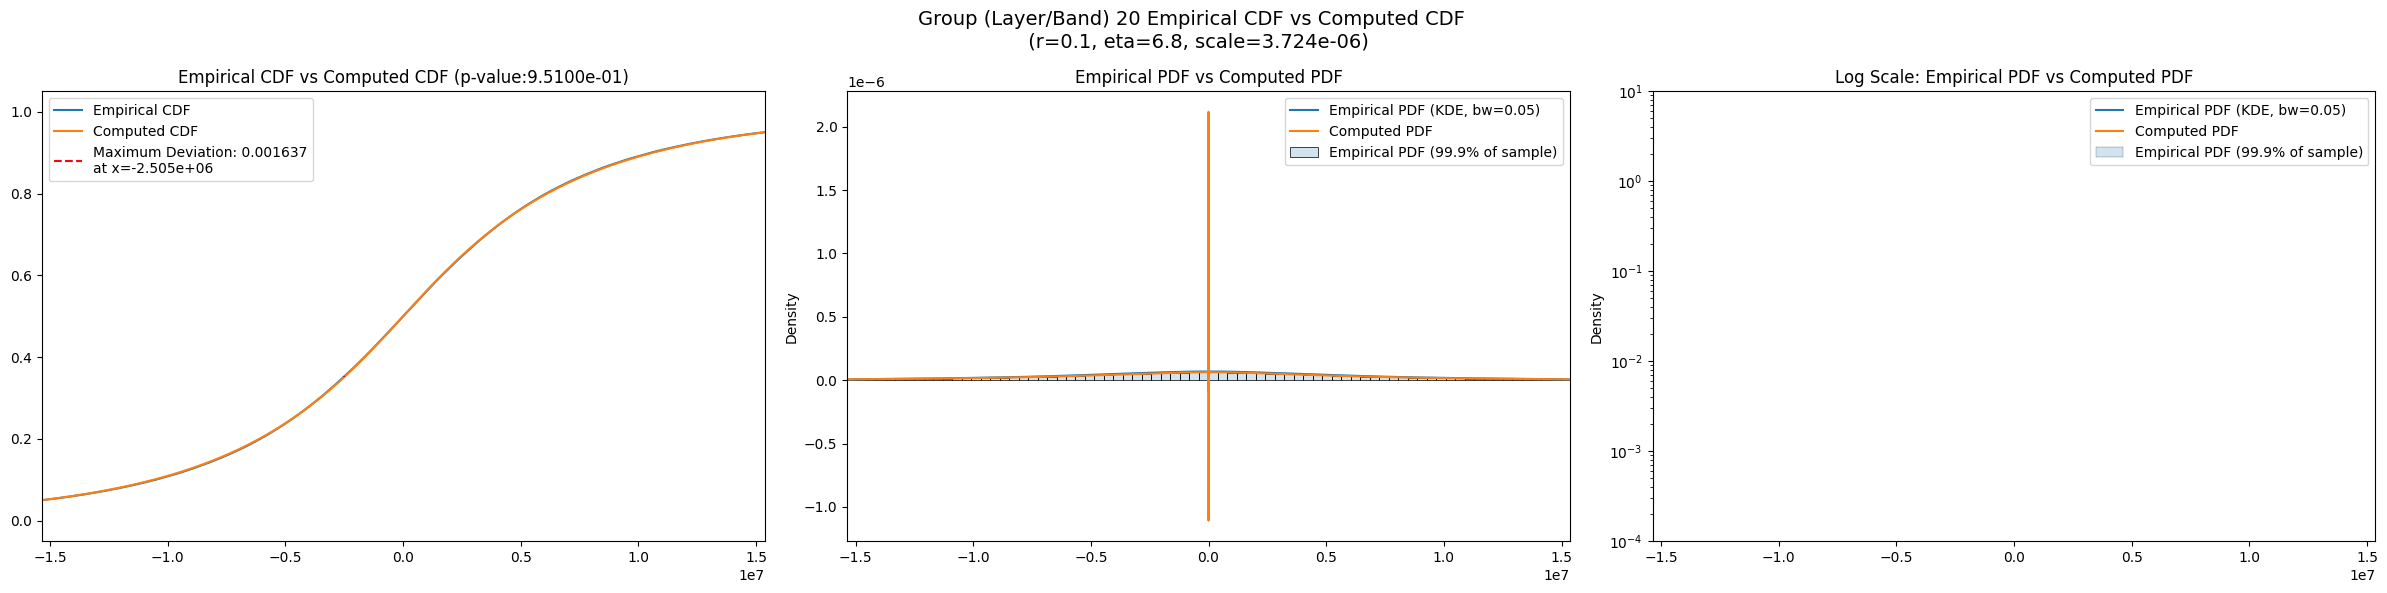

C:\Users\Henry\AppData\Local\Temp\ipykernel_17672\82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


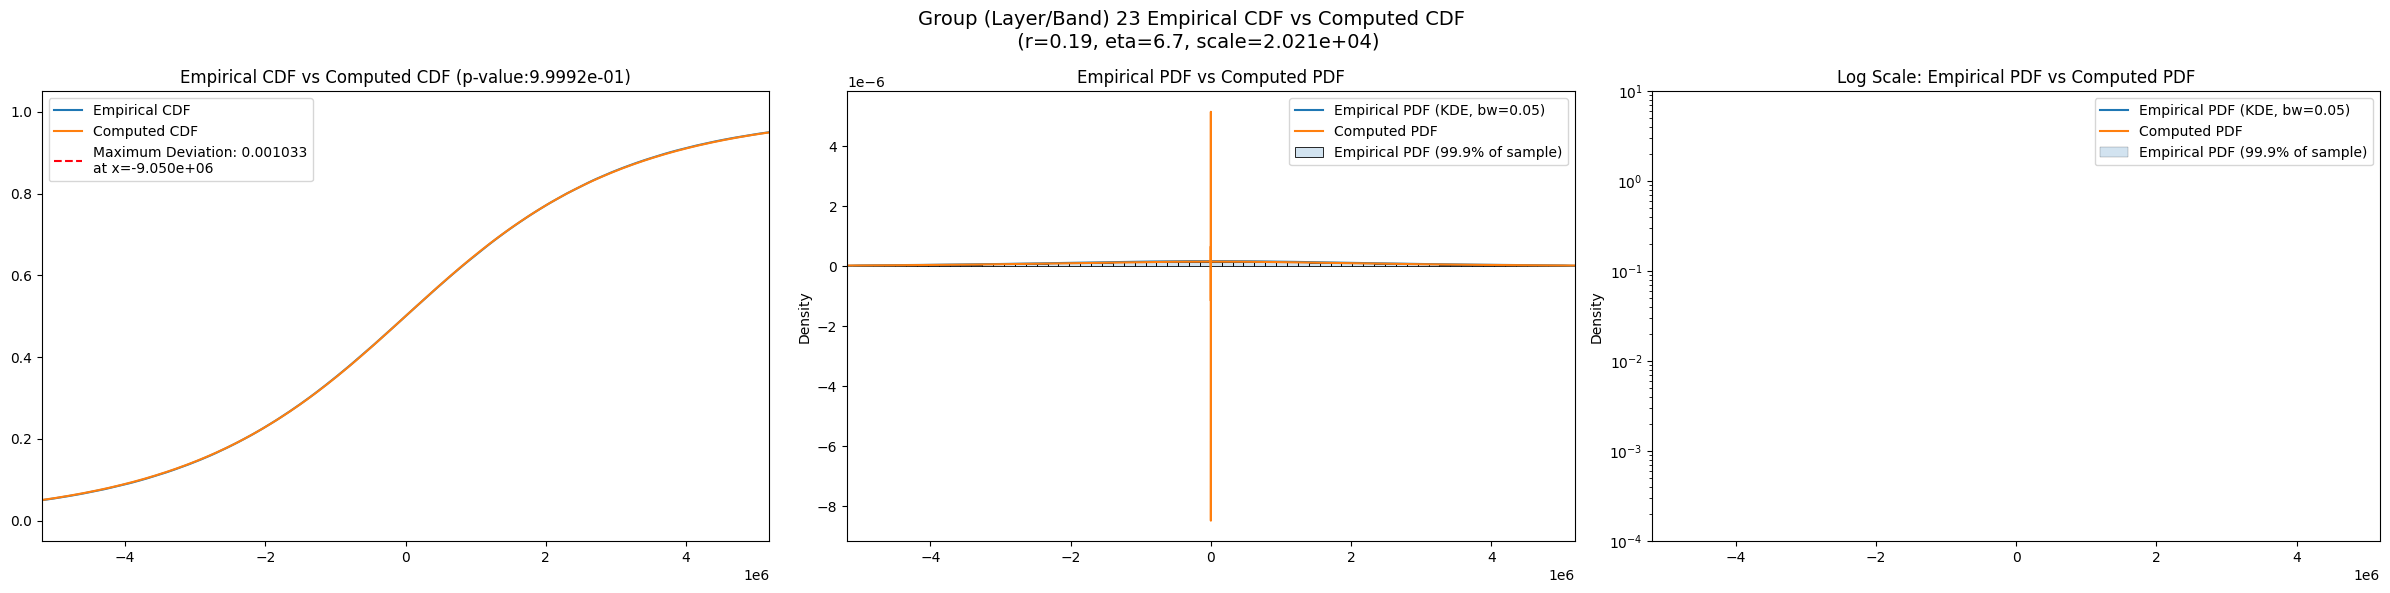

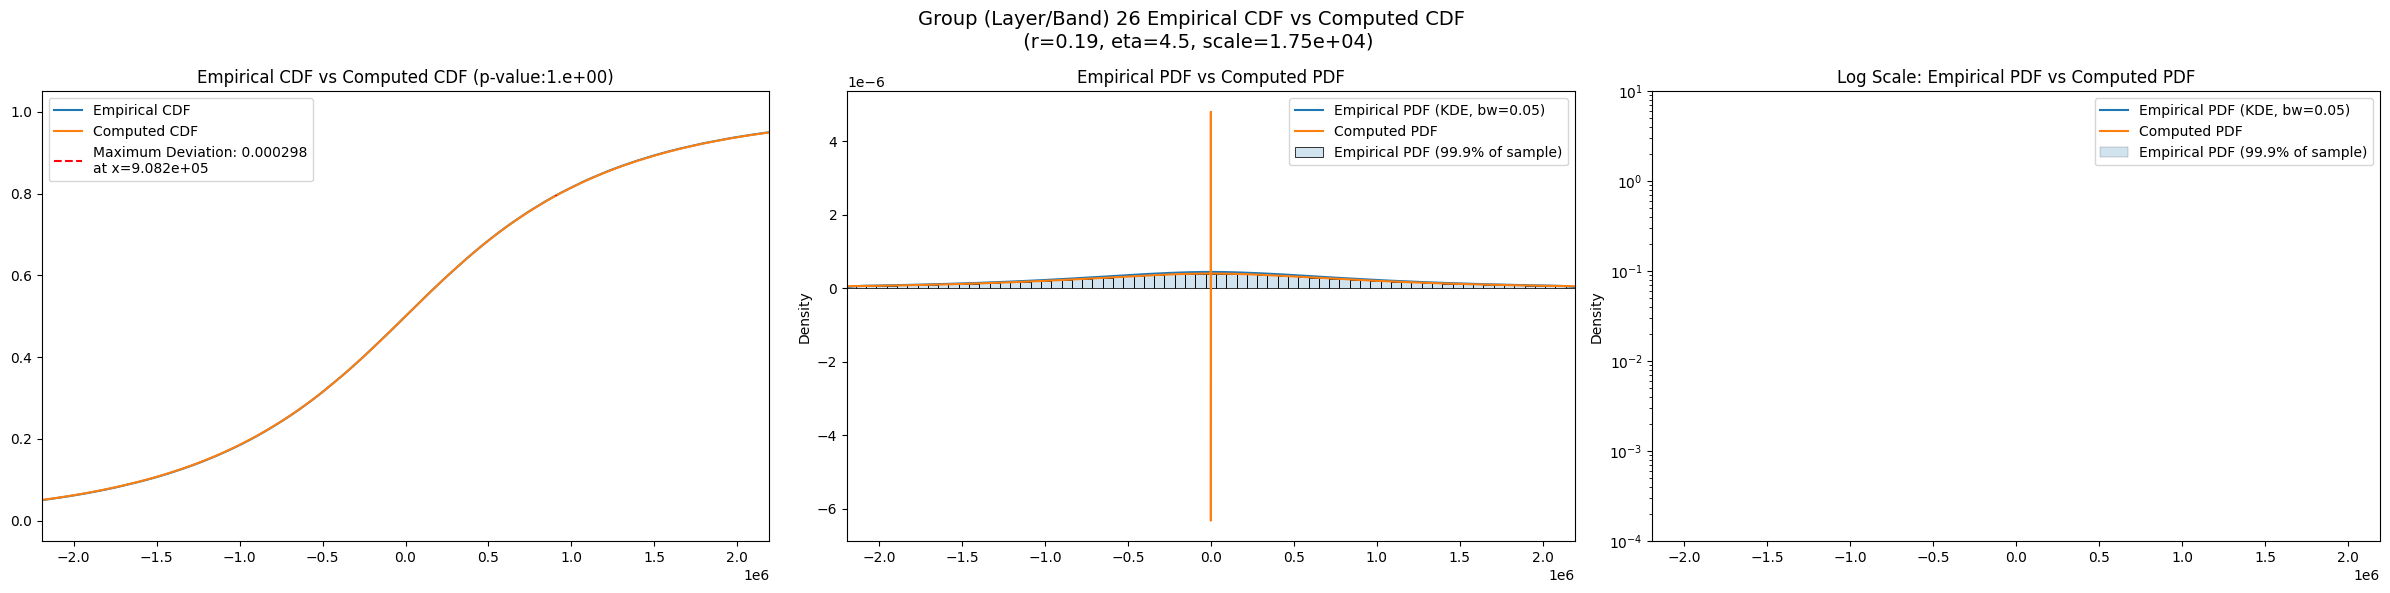

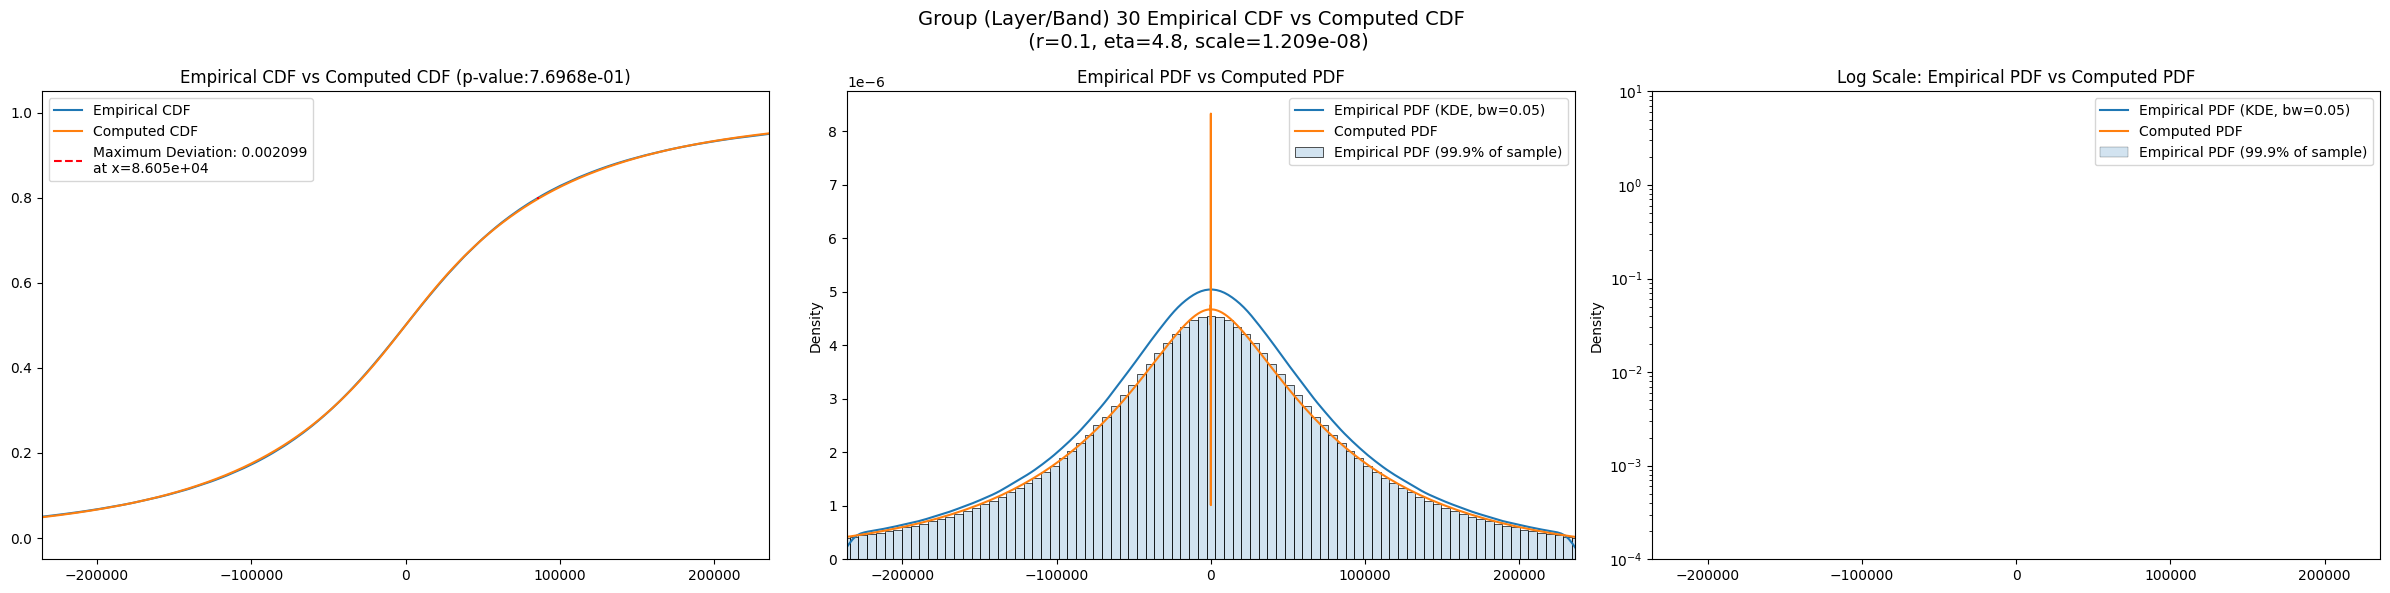

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     3.568306e+14  3.039798e+14  4.195499e+14    9.504944    4.874284   
5     7.959927e+14  7.029293e+14  8.967352e+14   17.538180   14.823676   
8     1.670649e+14  1.450703e+14  1.917868e+14   27.408527   18.534835   
11    1.355468e+13  1.069475e+13  1.834761e+13  121.738546   10.967462   
14    2.103183e+14  1.858708e+14  2.378472e+14   21.087435   14.737431   
17    3.977760e+14  3.729645e+14  4.249828e+14    4.405207    2.939635   
20    1.007255e+14  9.349251e+13  1.087113e+14    6.518887    4.131004   
23    1.091860e+13  1.026927e+13  1.167125e+13    4.128532    2.239955   
26    1.912489e+12  1.798811e+12  2.037603e+12    3.811173    2.372679   
30    2.431388e+10  2.244861e+10  2.633945e+10    7.504837    5.239296   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.495808         1440.0             0.010765        0.1          6.4   
5      20.252496         4320.0             0.013848        0.1          3.2   
8      40.507572        12240.0             0.010481        0.1          5.8   
11    309.820047        33840.0             0.003718        0.2          8.7   
14     31.797948        93600.0             0.022558        0.1         -0.1   
17      8.648835       100000.0             0.008528        0.1          6.0   
20     12.301920       100000.0             0.001637        0.1          6.8   
23     11.533251       100000.0             0.001044        0.2          6.3   
26      8.482887       100000.0             0.000396        0.2          4.2   
30     12.814057       100000.0             0.002099        0.1          4.8   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       1000000.0              0.418754         2.640530e-229   
5     ...       1000000.0              0.415392          0.000000e+00   
8     ...       1000000.0              0.354378          0.000000e+00   
11    ...       1000000.0              0.217463          0.000000e+00   
14    ...       1000000.0              0.197905          0.000000e+00   
17    ...       1000000.0              0.406834          0.000000e+00   
20    ...       1000000.0              0.357280          0.000000e+00   
23    ...       1000000.0              0.218835          0.000000e+00   
26    ...       1000000.0              0.041446         1.059400e-149   
30    ...        112867.0              0.032172          2.326820e-90   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         1000000.0             0.385774        2.353170e-193  1000000.0   
5         1000000.0             0.376886         0.000000e+00  1000000.0   
8         1000000.0             0.310486         0.000000e+00  1000000.0   
11        1000000.0             0.173673         0.000000e+00  1000000.0   
14        1000000.0             0.151349         0.000000e+00  1000000.0   
17        1000000.0             0.371744         0.000000e+00  1000000.0   
20        1000000.0             0.313728         0.000000e+00  1000000.0   
23        1000000.0             0.174456         0.000000e+00  1000000.0   
26        1000000.0             0.013413         4.686280e-16   825760.0   
30          97970.4             0.007440         3.094590e-05    80361.6   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.363033  1.494180e-170          9.956440e-01  
5          0.353546   0.000000e+00          3.754103e-01  
8          0.286498   0.000000e+00          1.371831e-01  
11         0.148719   0.000000e+00          7.363492e-01  
14         0.1272

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.010765                 0.035671          0.010765   
5                0.013848                 0.020624          0.013848   
8                0.010481                 0.012262          0.010448   
11               0.003718                 0.007378          0.003718   
14               0.022558                 0.004437          0.021996   
17               0.008528                 0.004293          0.008528   
20               0.001637                 0.004293          0.001637   
23               0.001044                 0.004293          0.001033   
26               0.000396                 0.004293          0.000298   
30               0.002099                 0.004293          0.002099   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.418754             0.385774       0.363033  
5                 0.415392             0.376886       0.353546  
8                 0.354378             0.310486       0.286498  
11                0.217463             0.173673       0.148719  
14                0.197905             0.151349       0.127229  
17                0.406834             0.371744       0.348592  
20                0.357280             0.313728       0.289739  
23                0.218835             0.174456       0.149490  
26                0.041446             0.013413       0.012773  
30                0.032172             0.007440       0.004665

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           3.568306e+14          0.010765    0.10      6.40  2.178560e-05   
5           4.813424e+14          0.013848    0.10      3.20  3.725247e-03   
8           8.629917e+13          0.010448    0.11      5.60  1.760081e-03   
11          9.174293e+12          0.003718    0.20      8.70  2.197692e+04   
14          1.910584e+14          0.021996    0.10     -0.11  4.865052e+01   
17          3.977760e+14          0.008528    0.10      6.00  3.970133e-05   
20          9.743147e+13          0.001637    0.10      6.80  3.723581e-06   
23          1.047510e+13          0.001033    0.19      6.70  2.021269e+04   
26          1.912489e+12          0.000298    0.19      4.50  1.749723e+04   
30          2.352464e+10          0.002099    0.10      4.80  1.208992e-08   

      best_exclude_cutoff  
band                       
2                     0.0  
5                    50.0  
8                   175.0  
11                  150.0  
14                   50.0  
17                    0.0  
20                   25.0  
23                   50.0  
26                    0.0  
30                   25.0